<div id="container" style="position:relative;">
<div style="float:left"><h1> Forecasting Bakery Sales - Abi Magnall </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://twomagpiesbakery.co.uk/wp-content/uploads/2020/11/logo-no-site.jpg" />
</div>
</div>

# Notebook 8 : Model 3 - SARIMAX Forecast

**Steps to calculate an SARIMAX model for a daily, weekly and monthly revenue forecast.**
 
In order for a successful SARIMAX model there are a few assumptions about the data that must be made, these are:

- The data is stationary 
- Residuals are normally distributed and show no significant correlation


If these are not met, revenue forecasts will be less accurate. 

**Accuracy Evaluation** 
The models will then be evaluated by calculating the:  
- Mean Absolute Percentage Error (MAPE) value, which is the percentage of the average absolute values of error between the true revenue values and the predicted ones. For full discussion on why this accuracy metric was determined please see `Model 2: Linear Regression Weekly Forecast`.

The model with the best evaluation scores will be selected as the optimal SARIMAX model for the daily, weekly and monthly forecast. 

---

# Contents 

**[Executive Summary](#Executive-Summary)**

**[Exploration into Trends](#Exploration-into-Trends)**

**[1. Daily Revenue Forecast](#1.-Daily-Revenue-Forecast)**

   - [Daily Revenue Model Results Discussion](#Daily-Revenue-Model-Results-Discussion)
    
**[2. Weekly Revenue Forecast](#2.-Weekly-Revenue-Forecast)**

   - [Weekly Revenue Model Results Discussion](#Weekly-Revenue-Model-Results-Discussion)

**[3. Monthly Revenue Forecast](#3.-Monthly-Revenue-Forecast)**

   - [Monthly Revenue Model Results Discussion](#Monthly-Revenue-Model-Results-Discussion)
    
**[Summary](#Summary)**

**[Further Improvements](#Further-Improvements)**

**[Next Steps](#Next-Steps)**
___

# Executive Summary 

- A total of 21 iterations were made for the daily, weekly and monthly forecasts, using a combination of decomposing and selecting hyperparameters and applying a grid search. 
- The best model for each are summarised in the table below with their MAPE scores and additional information about the hyperparameters and independent variables used. 
- Using SARIMAX has improved the accuracy scores compared to the Lienar Regression and Moving Average models, making them the most accurate so far. 

|Forecast| Model | MAPE | Independent Variables | Hyperparameters|
|:--| :- | :- | :- |:-|
|Daily|7| 5.9 %|TAVG, Bank_Holiday, Closed_Xmas, Weekend | p=1, d=2, q=1 | 
|Weekly|7| 8.2 %| Weekday, Bank_Holiday | p=0, d=2, q=1 |
|Monthly|5| 7.1 %| Bank_Holiday, Closed_Xmas, School_Holiday, Weekday, Weekend | p=3, d=2, q=1 |

Further improvements could be: 
-  Collecting and re-running the models with more data, in particular the weekly and monthly datasets
- Include statistical features from the historic dataset, such as lagged moving average 
- Run in depth cross validation, not just one fold 

--- 

## Imports

In [64]:
import numpy as np
import pandas as pd
import itertools
import joblib

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# stats
import statsmodels.api as sm
from statsmodels.api import tsa # time series analysis
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from scipy import stats

# time
import datetime as dt
import time
import os


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize']=[10,7.5]

In [65]:
start_time = time.time()

## Importing Custom Functions

In [66]:
import BakeryFunctions as bakery

## To Get Current Directory

In [67]:
working_directory = os.getcwd()
working_directory

'/Users/abimagnall/Documents/BrainStation/Capstone/Data'

## Importing Processed Datasets

In [68]:
total_rev = pd.read_csv(working_directory+'/5_timeseries_data/total_revenue_encoded.csv', index_col=0)
total_rev.index = pd.to_datetime(total_rev.index)
display(total_rev.head())

Total_Revenue  TAVG  PRCP  CPI_Electricity  CPI_Food  \
2020-09-01        9780.76  24.0  0.00            107.6     102.8   
2020-09-02       10037.55  27.0  0.00            107.6     102.8   
2020-09-03        9419.30  31.0  0.07            107.6     102.8   
2020-09-04       10606.15  27.0  0.08            107.6     102.8   
2020-09-05       12922.00  23.0  0.01            107.6     102.8   

            Bank_Holiday  Closed_Xmas  School_Holiday  Weekday  Weekend  
2020-09-01             0            0               0        1        0  
2020-09-02             0            0               0        1        0  
2020-09-03             0            0               0        1        0  
2020-09-04             0            0               0        1        0  
2020-09-05             0            0               0        0        1

---

# Exploration into Trends
SARIMAX models work by decomposing the data into the trend, seasonal and residual components. Therefore, it is required to understand the trends and seasonal components in the data, in order to enter the correct hyperparameters for an accurate model to be fitted. To do this, the data will be: 
- Trends and seasonality explored over time
- Data decomposed to be stationary (determine the baseline `d parameter`)
- Autocorrelation and Partial Autocorrelation Functions (ACF and PACF) plotted to determine baseline `p and q parameters`

## Exploring Revenue Trends

In [69]:
# To create the daily revenue dataframe
total_rev_daily = total_rev.drop(columns=['TAVG','PRCP','CPI_Electricity','CPI_Food',
                                         'Bank_Holiday','Closed_Xmas','School_Holiday','Weekday','Weekend']).copy()
total_rev_daily.head()

Total_Revenue
2020-09-01        9780.76
2020-09-02       10037.55
2020-09-03        9419.30
2020-09-04       10606.15
2020-09-05       12922.00

In [70]:
# To create the weekly revenue dataframe
total_rev_weekly = total_rev.resample('W').sum().round(2)
total_rev_weekly = total_rev_weekly[:-1]
total_rev_weekly.drop(columns=['TAVG', 'PRCP','CPI_Electricity','CPI_Food',
                              'Bank_Holiday','Closed_Xmas','School_Holiday','Weekday','Weekend'], inplace=True)
display(total_rev_weekly.head())

Total_Revenue
2020-09-06       62891.56
2020-09-13       64159.55
2020-09-20       65532.19
2020-09-27       58612.25
2020-10-04       52732.89

In [71]:
# To create the monthly revenue dataframe
total_rev_monthly = total_rev.resample('MS').sum().round(2)
total_rev_monthly.drop(columns=['TAVG','PRCP','CPI_Electricity','CPI_Food',
                               'Bank_Holiday','Closed_Xmas','School_Holiday','Weekday','Weekend'], inplace=True)
display(total_rev_monthly.head())

Total_Revenue
2020-09-01      271314.93
2020-10-01      267385.25
2020-11-01      143635.13
2020-12-01      173145.73
2021-01-01       95207.98

In [72]:
# Plot all revenue trends over time
rev_dfs = [total_rev_daily, total_rev_weekly, total_rev_monthly]
cols = ['Daily Revenue', 'Weekly Revenue', 'Monthly Revenue']
fig = make_subplots(rows=3, cols=1, subplot_titles=cols, vertical_spacing=0.05)

for i, df in enumerate(rev_dfs):
    fig.add_trace(
        go.Scatter(x=df.index, y=df['Total_Revenue']),
        row=i+1,
        col=1
    )

fig.update_layout(height=1000, width=1000, showlegend=False)
fig.show()

## Trend Observations 
All plots show: 
- A general increase in revenue over time 
- A seasonal trend, with revenue peaking in the summer months and dipping in the winter months 

## Seasonal Plot
In order to explore seasonality further and across multiple years the `seasonal plot` is used.

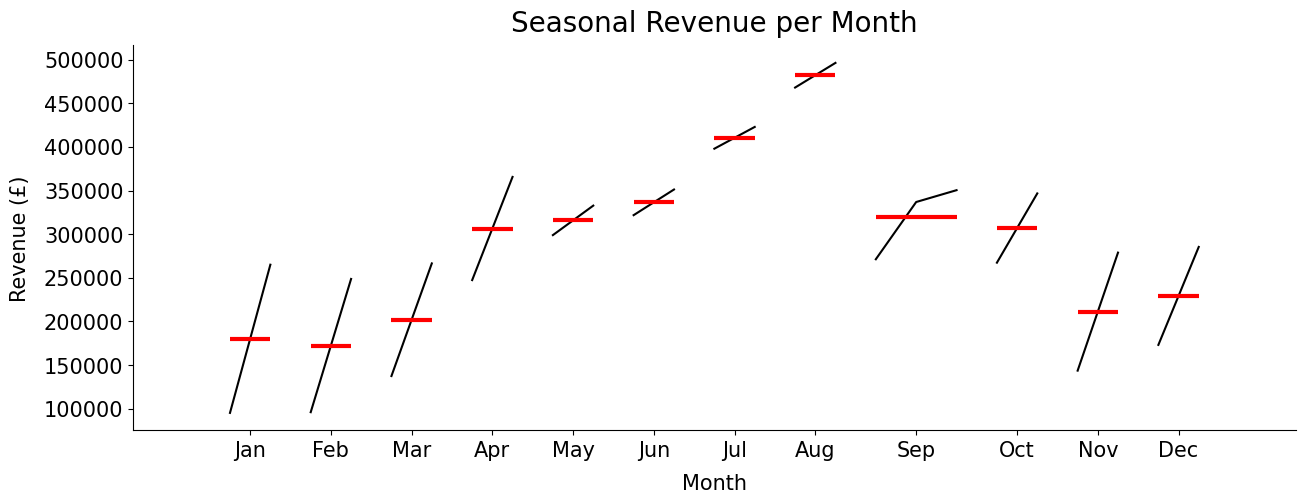

In [73]:
plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(total_rev_monthly['Total_Revenue'], ax=plt.gca())
plt.title('Seasonal Revenue per Month', fontsize=20, pad=10)
plt.ylabel('Revenue (£)', fontsize=15, labelpad=10)
plt.xlabel('Month', fontsize=15, labelpad=10)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
sns.despine()
plt.show()

## Seasonal Plot Observations
The red bars show the average for the given month across all years, while each black line represents an individual month and the progression of values across the years. 

- It can be seen the upward trend for each month and that on average that the late summer months (July and August) generate more revenue and the winter months perform least. 

Now the yearly periods are better understood, the average revenue for each month will be evaluated against how much it differs from the overall average.

In [74]:
# monthly average
monthly_mean = total_rev_monthly['Total_Revenue'].groupby(total_rev_monthly.index.month_name()).mean()
# relative deviation from the overall mean
monthly_mean_diff = round((monthly_mean - monthly_mean.mean())/monthly_mean,4)
# month names in right order
month_names = pd.date_range(start='2020-09', freq='M', periods=12).month_name()
# reorder columns to follow the month order
monthly_mean_diff = monthly_mean_diff.loc[month_names, ]

In [75]:
# To plot the monthly difference
fig = px.bar(monthly_mean_diff)

fig.update_layout(
    yaxis_title='', 
    yaxis_tickformat = '.0%',
    xaxis_title='',
    title='Monthly Deviation From Mean Monthly Revenue (%)',
    showlegend=False,
)
fig.show()

## Monthly Deviation Observations
It can be seen that the winter months November - Feburary deviate most from the mean monthly revenue. However, this could be due to the first winter season being in 2020, which was recently after the Covid Pandemic, therefore sales were perhaps lower than usual. 

---

# Trend-Seasonal Decomposition
A fundamental step in time series EDA is the trend-seasonal decomposition. Here, three series are extracted from the original observation:

- A trend component  𝑇𝑡  calculated using a moving average,
- A seasonal component  𝑆𝑡  which is the average of the de-trended series
- The residual  𝑅𝑡  that remains after subtracting the trend and seasonal component from the original series.

This is implemented using the `seasonal_decompose` function from the time series analysis module of statsmodels.

## Daily Decomposition
This is done using `additive` as opposed to `multiplicative`, which was determined by looking at the data, where the seasonal variation appears to be constant over time. Furthermore, multiplicative decomposition does not work if there a values of 0 in the dataset, which there are for the daily revenue from the 2 Christmas Days where the shop was closed. 

In [76]:
# decompose the time series
d_decomposition_add = tsa.seasonal_decompose(total_rev_daily, model='additive',
                                             period = 365, extrapolate_trend='freq')
daily_add_decom = total_rev_daily.copy()

In [77]:
# add the decomposition data
daily_add_decom['Trend'] = d_decomposition_add.trend
daily_add_decom['Seasonal'] = d_decomposition_add.seasonal
daily_add_decom['Residual'] = d_decomposition_add.resid
daily_add_decom['Original - trend'] = daily_add_decom['Total_Revenue'] - d_decomposition_add.trend

daily_add_decom.head(10)

Total_Revenue        Trend     Seasonal     Residual  \
2020-09-01        9780.76  6275.789062  1749.461864  1755.509074   
2020-09-02       10037.55  6285.266580  2109.639991  1642.643429   
2020-09-03        9419.30  6294.744098  3322.369826  -197.813924   
2020-09-04       10606.15  6304.221616  3198.352099  1103.576285   
2020-09-05       12922.00  6313.699134  2256.137085  4352.163781   
2020-09-06       10125.80  6323.176652   836.954953  2965.668395   
2020-09-07        9082.50  6332.654170   -20.477721  2770.323551   
2020-09-08        8559.20  6342.131689  -199.747686  2416.815998   
2020-09-09        8102.42  6351.609207    82.046190  1668.764603   
2020-09-10        8120.49  6361.086725  2909.168995 -1149.765720   

            Original - trend  
2020-09-01       3504.970938  
2020-09-02       3752.283420  
2020-09-03       3124.555902  
2020-09-04       4301.928384  
2020-09-05       6608.300866  
2020-09-06       3802.623348  
2020-09-07       2749.845830  
2020-09-08       2217.068311  
2020-09-09       1750.810793  
2020-09-10       1759.403275

In [78]:
cols = ['Total_Revenue','Trend', 'Original - trend', 'Seasonal', 'Residual']
fig = make_subplots(rows=5, cols=1, subplot_titles=cols, vertical_spacing=0.05)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=daily_add_decom.index, y=daily_add_decom[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=1000, width=1000, showlegend=False)
fig.show()

## Observations 
- The trend is clearly upward, with a big step around April 2022 - this is most likely due to the Easter holidays / bank holiday. 

- The seasonal plot shows that revenue peaks in the summer months and dips in the winter months, with a sharp decline on December 25th, where the shops were closed for Christmas Day. 

- The residual still shows some seasonality, however it is very minimal. This will be further decomposed to reduce the seasonality in the differencing stage of the SARIMAX model. 

# Selecting Baseline Hyperparameters
For the baseline model, the hyperparameters need to be determined. These parameters are: 
- p: Trend autoregression order
- d: Trend difference order
- q: Trend moving average order
- P: Seasonal autoregressive order
- D: Seasonal difference order
- Q: Seasonal moving average order
- m: The number of time steps for a single seasonal period

For daily revenue `m` is equal to 7 (as there are 7 days in the seasonal period), 52 for weekly revenue and 12 for monthly revenue.  

To determine the `d` value, this is done by testing if the data is stationary. This is an assumption that must be met for an accurate SARIMAX model. This is important as when running a linear regression, it is assumed that all the observations are independent from one another. However, in a time series that is often not the case, and is not for bakery revenue, therefore the data must be made stationary so that regression techniques can be applied. 

---

# 1. Daily Revenue Forecast
## Selecting Baseline Parameters 
First the original daily data and differenced data will be visualised to see if the data becomes stationary and then the `Dickey-Fuller Test` can be run to confirm that it is. The weekly and monthly will have be decomposed later in [2. Weekly Revenue Forecast](#2.-Weekly-Revenue-Forecast) and [3. Monthly Revenue Forecast](#3.-Monthly-Revenue-Forecast)

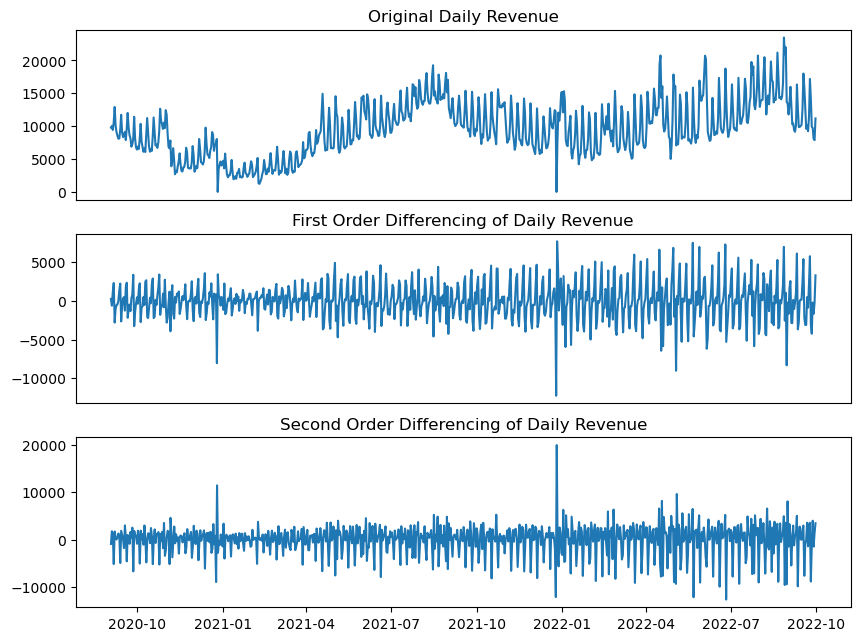

In [79]:
# Subplots of orginal and differenced daily data 
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(daily_add_decom['Total_Revenue']); ax1.set_title('Original Daily Revenue'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(daily_add_decom['Total_Revenue'].diff()); ax2.set_title('First Order Differencing of Daily Revenue'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(daily_add_decom['Total_Revenue'].diff().diff()); ax3.set_title('Second Order Differencing of Daily Revenue')
plt.show()

## Observations
It appears that the first and second order differenced data is stationary as the plot above shows: 
- There is no clear trend in the new series,
- The variance is relatively constant, and
- There is no seasonality 

The second order differenced dataset appears to be more stationary than the first order. This can be confirmed using the `Dickey-Fuller Test`. 

## Dickey-Fuller Test for Stationarity
Null hypothesis: 

$H$<sub>0</sub>: The time series is non-stationary, meaning it has some time-dependent structure and does not have constant variance over time.


$H$<sub>A</sub>: The time series is stationary.

In [80]:
#perform augmented Dickey-Fuller test
adfuller(daily_add_decom['Total_Revenue'].diff().diff().dropna())

(-12.889893541644302,
 4.471712378090714e-24,
 20,
 737,
 {'1%': -3.4392539652094154,
  '5%': -2.86546960465041,
  '10%': -2.5688625527782327},
 12969.587710892225)

**Dickey-Fuller Test Output**

|Revenue| Test Statistic | p-value |
|:--| :- | :- | 
|Daily|-12.890| 4.472 *e*<sup>-11</sup>|

The p-value is less than 0.05, therefore can reject the null hypothesis that the time series is non-stationary. Therefore, the `d parameter` for the baseline model shall be 2. 

---

## Determining the `p` and `q` Parameters for Daily Baseline
Autocorrelation plots help determine if the successive elements of a time series are positively correlated, negatively correlated, or independent of each other. Analysing the autocorrelations is a key step in finding the right `p` and `q` parameters for (autoregressive) time series models.

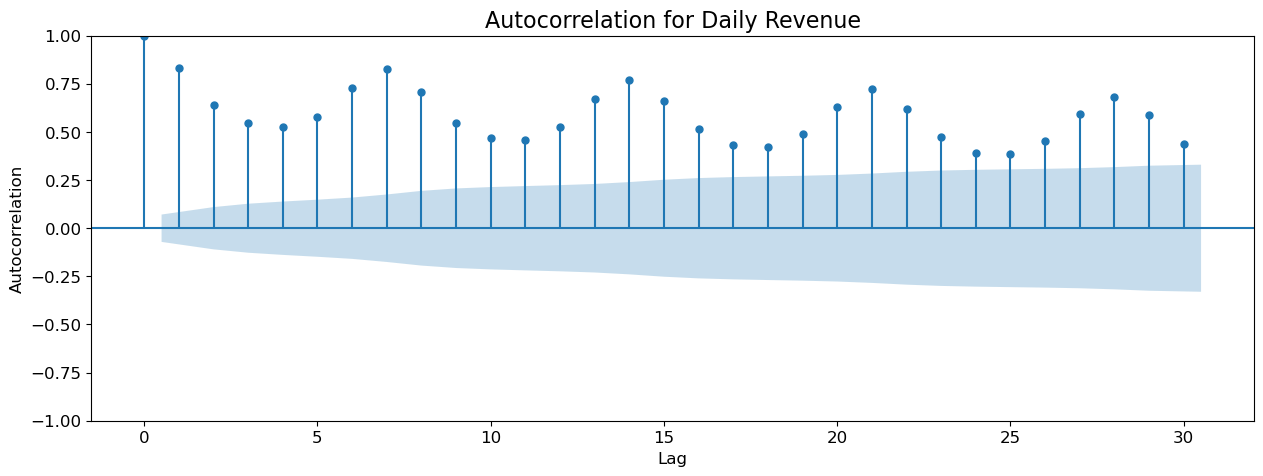

In [81]:
# Plotting autocorrelation plot on the original daily dataset
plt.figure(figsize=(15, 5))
plot_acf(daily_add_decom['Total_Revenue'], lags=30, ax=plt.gca())
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Autocorrelation for Daily Revenue', fontsize=16)
plt.show()

**ACF Plot Observations**: Looking at the original revenue first, the seasonality of the data is clearly visible in the autocorrelation plot as as each lag is correlated to the every other lag, peaking on multiples of 7 (for each week). 

Therefore, the differenced data will be plotted to determine the p and q parameters required for the baseline model. 

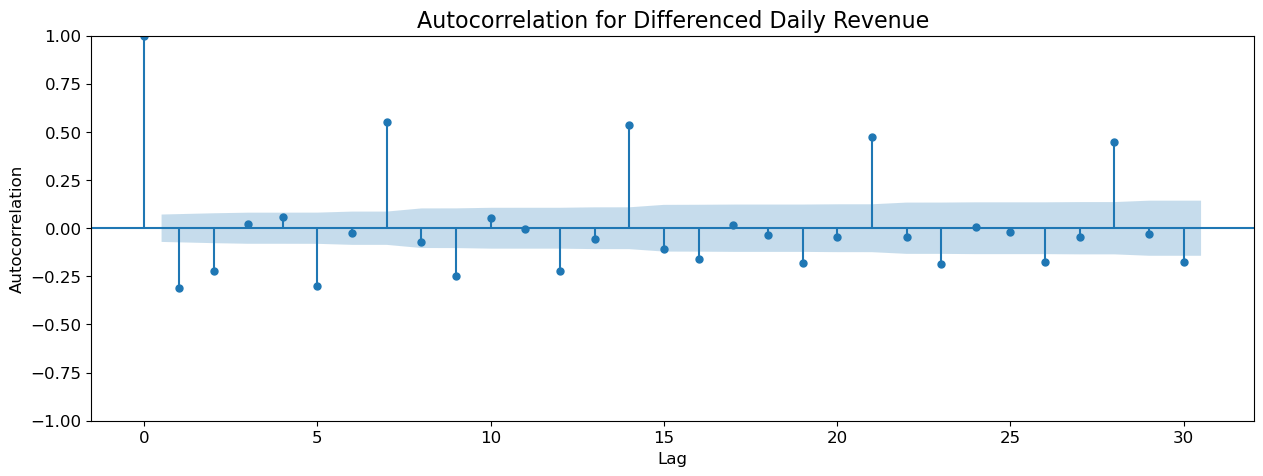

In [82]:
# Plotting the autocorrelation of the differenced data 
plt.figure(figsize=(15, 5))
plot_acf(daily_add_decom['Total_Revenue'].diff().diff().dropna(), lags=30, ax=plt.gca())
plt.ylabel('Autocorrelation', fontsize=12)
plt.xlabel('Lag', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Autocorrelation for Differenced Daily Revenue', fontsize=16)
plt.show()

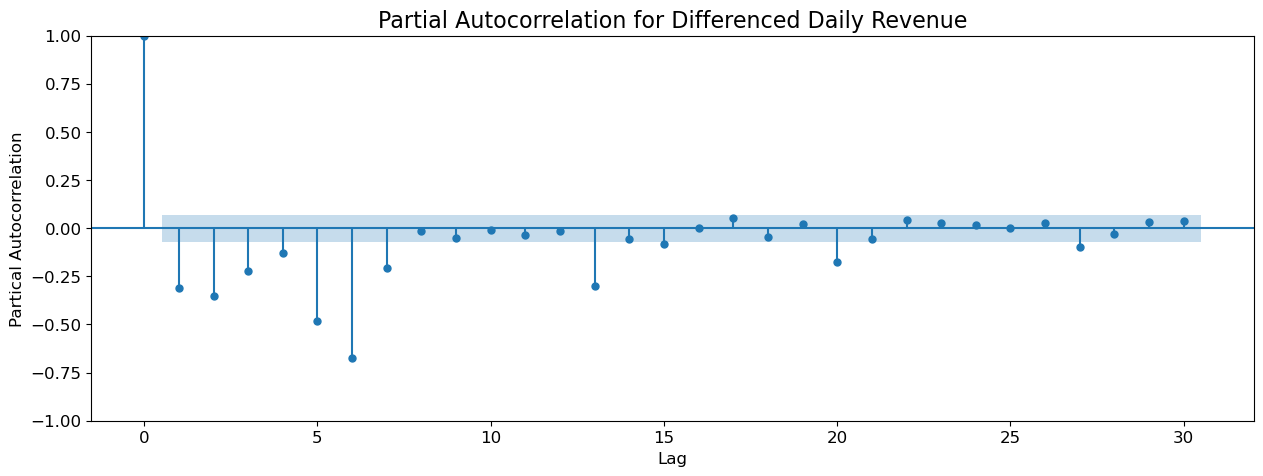

In [83]:
# To plot the partial autocorrelation of differenced data 
plt.figure(figsize=(15, 5))
plot_pacf(daily_add_decom['Total_Revenue'].diff().diff().dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Partical Autocorrelation', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Partial Autocorrelation for Differenced Daily Revenue', fontsize=16)
plt.show()

## ACF and PACF Observations
Picking the right order parameter `p` and `q` , should include all or most of the significant correlations in the PACF plot.
- From the PACF plot it can be seen that `p = 7` for the daily baseline model

- From the ACF plot, it can be determined that for the baseline model `q = 2`. 

## Splitting the Series for Evaluation

First the data is split into train and test sets as determined by the business, which is to predict the next 7 days of revenue.

*Therefore, anything before the date 24-09-2022 is the train dataset and on or post is test dataset.*

In [84]:
# Splitting the train and test data
train_daily= pd.DataFrame(daily_add_decom.loc[daily_add_decom.index <= '2022-09-23', 'Total_Revenue'].dropna().copy())
test_daily = pd.DataFrame(daily_add_decom.loc[daily_add_decom.index > '2022-09-23', 'Total_Revenue'].copy())

---

# Model 1 - Baseline SARIMAX
For the first baseline SARIMAX model, a model will be run using the following parameters: 
- p = 7
- d = 2
- q = 2

As determined by the above stationary tests, ACF and PACF plots. 

In [85]:
# First an empty results dataframe is created to track the accuracy of the models run
daily_model_scores = pd.DataFrame()

In [86]:
# Baseline model run 
p_param = 7
d_param = 2
q_param = 2

model = SARIMAX(train_daily, order=(p_param, d_param, q_param), seasonal_order = (0, 2, 2, 7), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                     Total_Revenue   No. Observations:                  753
Model:             SARIMAX(7, 2, 2)x(0, 2, 2, 7)   Log Likelihood               -6686.430
Date:                           Thu, 03 Nov 2022   AIC                          13398.860
Time:                                   20:43:37   BIC                          13458.694
Sample:                               09-01-2020   HQIC                         13421.934
                                    - 09-23-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0309      0.078      0.396      0.692      -0.122       0.184
ar.L1         -1.2031      0.093    -12.921      0.000      -1.386      -1.021
ar.L2         -0.5656      0.137     -4.139      0.000      -0.833      -0.298
ar.L3         -0.5035      0.172     -2.919      0.004      -0.842      -0.165
ar.L4         -0.2627      0.199     -1.319      0.187      -0.653       0.128
ar.L5         -0.4542      0.199     -2.287      0.022      -0.843      -0.065
ar.L6         -0.4925      0.193     -2.548      0.011      -0.871      -0.114
ar.L7         -0.1321      0.136     -0.971      0.331      -0.398       0.134
ma.L1          0.0149      0.095      0.157      0.875      -0.171       0.201
ma.L2         -0.9528      0.071    -13.396      0.000      -1.092      -0.813
ma.S.L7       -1.9447      0.062    -31.576      0.000      -2.065      -1.824
ma.S.L14       0.9489      0.063     15.175      0.000       0.826       1.071
sigma2      8.454e+06   1.07e-08   7.91e+14      0.000    8.45e+06    8.45e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.22   Jarque-Bera (JB):              6898.98
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                            -1.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.23e+30. Standard errors may be unstable.
"""

In [87]:
predictions_1 = model_fit.predict(start=0, end=len(train_daily)+len(test_daily)-1)

In [88]:
bakery.train_forecast_plot(train_daily,test_daily, predictions_1, 'Model 1 - Baseline Daily Forecast')

In [89]:
bakery.full_accuracy_report(test_daily, predictions_1[test_daily.index], 'daily forecast')

The R2 for the daily forecast is: 0.852

The RMSE for the daily forecast is: 1210.26

The MAE between the actual and daily forecast revenue is 927.75

The MAPE between the actual and daily forecast revenue is 10.5%


## Model 1 Daily Accuracy Evaluation 
The baseline model produced a high R<sup>2</sup> value and a relatively low MAPE score, better than the moving average model and only 3% greater than the Linear Regression model. To further try and improve the results, the train dataset will be passed through a grid search to tune the hyperparameters.

In [90]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 1, 0.852, 1210.26, 13398.860, '10.5%', 'p=7, d=2, q=2')

Model     R2     RMSE       AIC MAPE (%)       Comments
0      1  0.852  1210.26  13398.86    10.5%  p=7, d=2, q=2

# SARIMAX Grid Search to Tune Hyperparameters
To tune the hyperparameters for the SARIMAX model, the `evaluate_models` and `evaluate_sarimax_model` functions are used. 

These functions work by trying multiple orders of p,d,q and seasonal order parameters, as inputted and determining which combination creates a model with the lowest MAPE score. This is done on train data only, which is split 90% train and 10% validation set so that no test data leaks into the model creating an inaccurate and overfitted model. 90% was selected as this most similarly represents the true train / test split. 

**N.B** *The grid search has been commented out to reduce run time of the notebook. An image of the results can be found in the below code cell.*

In [91]:
# # Grid search to evaluate parameters
# p_values = [0, 1, 2, 4, 6, 7]
# d_values = range(0, 3)
# q_values = range(0, 3)
# s_range = range(0,2)
# warnings.filterwarnings("ignore")
# bakery.evaluate_models(train_daily.values, p_values, d_values, q_values, None, s_range, 7, 0.9)

*Image of the results from the above grid search*
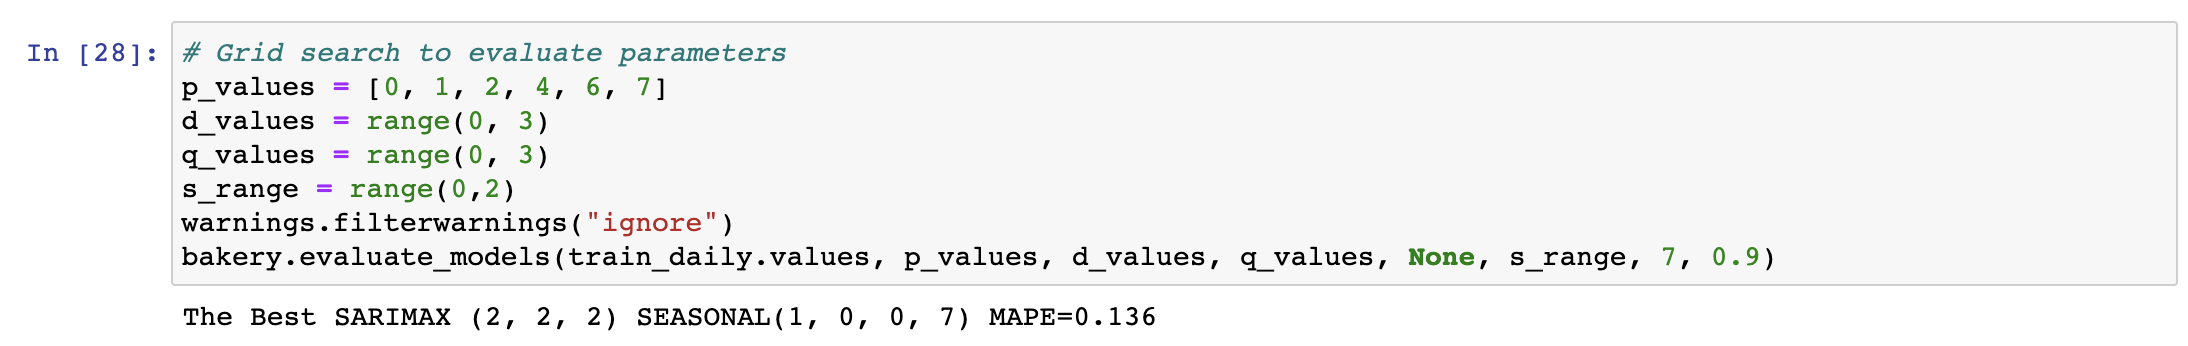

# Model 2 - SARIMAX with Tuned Hyperparameters
The model will be re-fitted with the tuned hyperparameters.

In [92]:
# Best hyperparameters 
p_param = 2
d_param = 2
q_param = 2

model = SARIMAX(train_daily, order=(p_param, d_param, q_param), seasonal_order = (1, 0, 0, 7), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Total_Revenue   No. Observations:                  753
Model:             SARIMAX(2, 2, 2)x(1, 0, [], 7)   Log Likelihood               -6690.310
Date:                            Thu, 03 Nov 2022   AIC                          13394.620
Time:                                    20:43:38   BIC                          13426.970
Sample:                                09-01-2020   HQIC                         13407.084
                                     - 09-23-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1496      0.478     -0.313      0.754      -1.086       0.787
ar.L1         -1.0015      0.063    -15.923      0.000      -1.125      -0.878
ar.L2         -0.0560      0.032     -1.770      0.077      -0.118       0.006
ma.L1         -0.1164      0.067     -1.730      0.084      -0.248       0.016
ma.L2         -0.8836      0.060    -14.694      0.000      -1.002      -0.766
ar.S.L7        0.6924      0.021     33.506      0.000       0.652       0.733
sigma2      3.151e+06    1.5e-08   2.11e+14      0.000    3.15e+06    3.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              2764.47
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.49   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.39e+30. Standard errors may be unstable.
"""

In [93]:
predictions_2 = model_fit.predict(start=0, end=len(train_daily)+len(test_daily)-1)

In [94]:
bakery.train_forecast_plot(train_daily,test_daily, predictions_2, 'Model 2 - Grid Search Daily Forecast')

In [95]:
bakery.full_accuracy_report(test_daily, predictions_2[test_daily.index], 'daily forecast')

The R2 for the daily forecast is: 0.841

The RMSE for the daily forecast is: 1255.7

The MAE between the actual and daily forecast revenue is 1136.67

The MAPE between the actual and daily forecast revenue is 10.7%


## Model 2 Daily Accuracy Evaluation 
This has slightly decreased the accuracy of the model compared to the baseline model. This could be due to the grid search being run on the train dataset only and has therefore overfit. 

It can be seen that one of the moving average and autoregressive coefficients have p-values greater than 0.05. Therefore, these will be reduced in the next iteration. 

In [96]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 2, 0.841, 1255.7, 13394.620, '10.7%', 'p=2, d=2, q=2')

Model     R2     RMSE       AIC MAPE (%)       Comments
0      1  0.852  1210.26  13398.86    10.5%  p=7, d=2, q=2
1      2  0.841  1255.70  13394.62    10.7%  p=2, d=2, q=2

# Model 3 - Reducing `p_param` and `q_param`
From the above summary table, it can be seen that one of the moving average and one of the autoregressive coefficients have p-values greater than 0.05, therefore aren't deemed statistically significant. Therefore, for the next iteration of the model, the `p` and `q` parameters will be reduced to 1. 

In [97]:
# Reducing p and q hyperparameters 
p_param = 1
d_param = 2
q_param = 1

model = SARIMAX(train_daily, order=(p_param, d_param, q_param), seasonal_order = (1, 0, 0, 7), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Total_Revenue   No. Observations:                  753
Model:             SARIMAX(1, 2, 1)x(1, 0, [], 7)   Log Likelihood               -6698.670
Date:                            Thu, 03 Nov 2022   AIC                          13407.340
Time:                                    20:43:39   BIC                          13430.447
Sample:                                09-01-2020   HQIC                         13416.243
                                     - 09-23-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0820      0.257     -0.319      0.750      -0.586       0.422
ar.L1         -0.1447      0.020     -7.131      0.000      -0.184      -0.105
ma.L1         -1.0000      0.025    -39.608      0.000      -1.049      -0.951
ar.S.L7        0.6815      0.020     33.378      0.000       0.642       0.722
sigma2      3.222e+06   7.84e-09   4.11e+14      0.000    3.22e+06    3.22e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              2782.76
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                            -1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.5e+30. Standard errors may be unstable.
"""

In [98]:
predictions_3 = model_fit.predict(start=0, end=len(train_daily)+len(test_daily)-1)

In [99]:
bakery.train_forecast_plot(train_daily,test_daily, predictions_3, 'Model 3 - Reducing the p and q Parameters')

In [100]:
bakery.full_accuracy_report(test_daily, predictions_3[test_daily.index], 'daily forecast')

The R2 for the daily forecast is: 0.835

The RMSE for the daily forecast is: 1279.86

The MAE between the actual and daily forecast revenue is 1158.97

The MAPE between the actual and daily forecast revenue is 10.8%


## Model 3 Daily Accuracy Evaluation 
This improved the p-values of all the coefficients, which are now below the threshold of 0.05 and can be considered to be statistically significant. However, it did not improve the accuracy of the model. 

Exogenous data, including the `Day` type and `TAVG` which have been identified to be good predictors and highly correlated with the target `Total_Revenue`, will be added in the next iteration. 

In [101]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 3, 0.835, 1279.86, 13407.340, '10.8%', 'p=1, d=2, q=1')

Model     R2     RMSE       AIC MAPE (%)       Comments
0      1  0.852  1210.26  13398.86    10.5%  p=7, d=2, q=2
1      2  0.841  1255.70  13394.62    10.7%  p=2, d=2, q=2
2      3  0.835  1279.86  13407.34    10.8%  p=1, d=2, q=1

# Model 4 - Adding Exogenous Data
For the next iteration of the model, special days and average temperature data will be added to see if this improves the models MAPE accuracy score. The same initial hyperparameters will be used from the baseline model. 

In [102]:
exogenous_variables = total_rev[['TAVG','Bank_Holiday','Closed_Xmas','School_Holiday','Weekday','Weekend']].copy()
# Splitting the train and test data
train_ex = exogenous_variables.loc[exogenous_variables.index <= '2022-09-23'].copy()
test_ex = exogenous_variables.loc[exogenous_variables.index > '2022-09-23'].copy()

In [103]:
# Baseline model run with special dates added
p_param = 7
d_param = 2
q_param = 2

model = SARIMAX(train_daily, order=(p_param, d_param, q_param), seasonal_order = (0, 2, 2, 7), 
                exog=train_ex, trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                     Total_Revenue   No. Observations:                  753
Model:             SARIMAX(7, 2, 2)x(0, 2, 2, 7)   Log Likelihood               -6555.813
Date:                           Thu, 03 Nov 2022   AIC                          13149.626
Time:                                   20:43:51   BIC                          13237.075
Sample:                               09-01-2020   HQIC                         13183.349
                                    - 09-23-2022                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0101      0.092     -0.110      0.912      -0.190       0.170
TAVG              39.7157     55.710      0.713      0.476     -69.473     148.905
Bank_Holiday    3445.0777   1.16e+04      0.296      0.767   -1.94e+04    2.63e+04
Closed_Xmas    -5268.7596   1.14e+04     -0.461      0.645   -2.77e+04    1.71e+04
School_Holiday  1204.3546   1.15e+04      0.104      0.917   -2.14e+04    2.38e+04
Weekday         -122.8679   1.16e+04     -0.011      0.992   -2.29e+04    2.27e+04
Weekend          742.1996   1.15e+04      0.065      0.949   -2.18e+04    2.33e+04
ar.L1             -0.6469      6.708     -0.096      0.923     -13.795      12.501
ar.L2             -0.3174      1.767     -0.180      0.857      -3.780       3.146
ar.L3             -0.2171      1.487     -0.146      0.884      -3.131       2.697
ar.L4             -0.1489      0.918     -0.162      0.871      -1.948       1.650
ar.L5             -0.2452      0.699     -0.351      0.726      -1.615       1.125
ar.L6             -0.1424      1.451     -0.098      0.922      -2.987       2.702
ar.L7             -0.0074      0.537     -0.014      0.989      -1.059       1.044
ma.L1             -0.6002      6.712     -0.089      0.929     -13.756      12.555
ma.L2             -0.3836      6.621     -0.058      0.954     -13.361      12.594
ma.S.L7           -1.7796      0.125    -14.283      0.000      -2.024      -1.535
ma.S.L14           0.7937      0.126      6.295      0.000       0.547       1.041
sigma2          6.295e+06     32.220   1.95e+05      0.000     6.3e+06     6.3e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               699.27
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.93e+21. Standard errors may be unstable.
"""

In [104]:
predictions_4 = model_fit.predict(start=0, end=len(train_daily)+len(test_daily)-1, exog=test_ex)

In [105]:
bakery.train_forecast_plot(train_daily, test_daily, predictions_4, 'Model 4 - Baseline Adding Special Days and TAVG')

In [106]:
bakery.full_accuracy_report(test_daily, predictions_4[test_daily.index], 'daily forecast with special days and TAVG')

The R2 for the daily forecast with special days and TAVG is: 0.948

The RMSE for the daily forecast with special days and TAVG is: 714.97

The MAE between the actual and daily forecast with special days and TAVG revenue is 592.65

The MAPE between the actual and daily forecast with special days and TAVG revenue is 6.5%


## Model 4 Daily Accuracy Evaluation 
This has dramatically improved the accuracy of the model, achieving the best MAPE scores so far achieved by any model.

As this was the baseline model, it will be based through the grid search function to tune the hyperpaprameters. 

In [107]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores,
                                        4, 0.948, 714.97, 13149.626, '6.5%', 'Adding special dates and TAVG')

Model     R2     RMSE        AIC MAPE (%)                       Comments
0      1  0.852  1210.26  13398.860    10.5%                  p=7, d=2, q=2
1      2  0.841  1255.70  13394.620    10.7%                  p=2, d=2, q=2
2      3  0.835  1279.86  13407.340    10.8%                  p=1, d=2, q=1
3      4  0.948   714.97  13149.626     6.5%  Adding special dates and TAVG

# Model 5 - Grid Search with Exogenous Data
**N.B** *The grid search has been commented out to reduce run time of the notebook. An image of the results can be found in the below code cell.*

In [108]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 7]
d_values = range(0, 3)
q_values = range(0, 3)
s_range = range(0,2)
warnings.filterwarnings("ignore")
# bakery.evaluate_models(train_daily.values, p_values, d_values, q_values, train_ex, s_range, 7, 0.9)

*Image of the results from the above grid search*
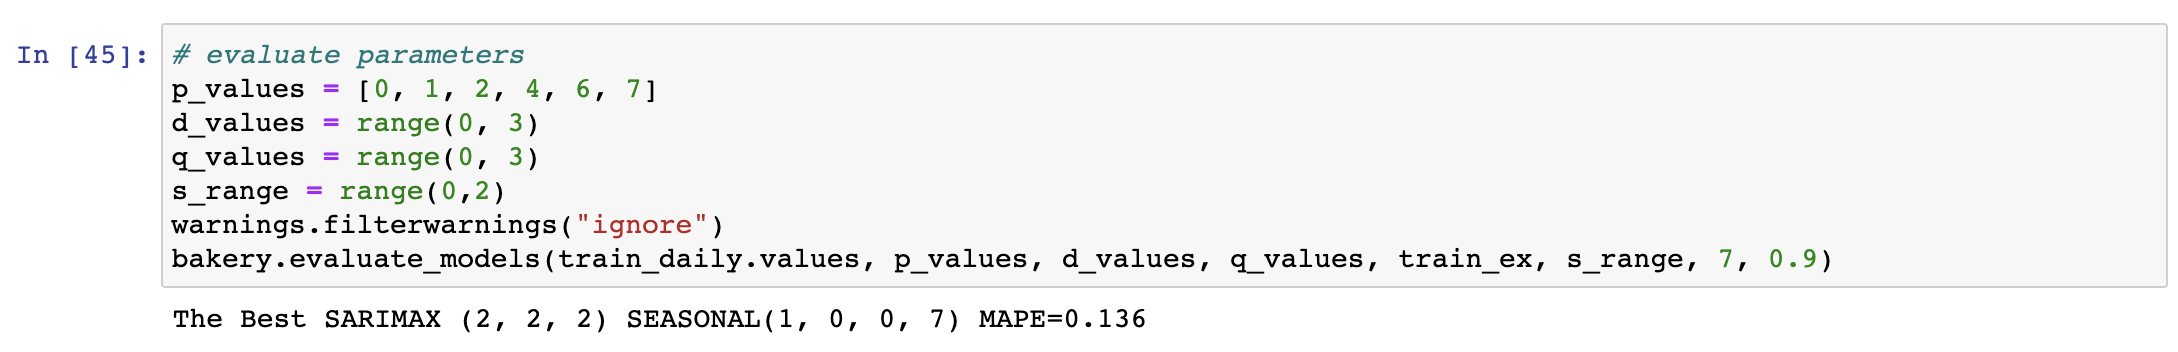

In [109]:
# Fit with the best hyperparameters
p_param = 2
d_param = 2
q_param = 2

model = SARIMAX(train_daily, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (1, 0, 0, 7), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Total_Revenue   No. Observations:                  753
Model:             SARIMAX(2, 2, 2)x(1, 0, [], 7)   Log Likelihood               -6549.215
Date:                            Thu, 03 Nov 2022   AIC                          13124.430
Time:                                    20:43:52   BIC                          13184.508
Sample:                                09-01-2020   HQIC                         13147.578
                                     - 09-23-2022                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0951      0.461      0.206      0.836      -0.808       0.998
TAVG              89.7516     14.297      6.278      0.000      61.731     117.772
Bank_Holiday    3258.5802    880.955      3.699      0.000    1531.941    4985.219
Closed_Xmas    -6051.9584    888.323     -6.813      0.000   -7793.040   -4310.876
School_Holiday  1591.2543    879.616      1.809      0.070    -132.761    3315.270
Weekday         -543.1693    842.374     -0.645      0.519   -2194.192    1107.854
Weekend         1747.9031    851.419      2.053      0.040      79.153    3416.653
ar.L1             -1.0592      0.114     -9.323      0.000      -1.282      -0.837
ar.L2             -0.1228      0.052     -2.351      0.019      -0.225      -0.020
ma.L1             -0.1133      0.121     -0.936      0.349      -0.351       0.124
ma.L2             -0.8867      0.105     -8.436      0.000      -1.093      -0.681
ar.S.L7            0.6970      0.027     25.736      0.000       0.644       0.750
sigma2          2.455e+06      0.004   6.48e+08      0.000    2.45e+06    2.45e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):               215.70
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.64e+28. Standard errors may be unstable.
"""

In [110]:
predictions_5 = model_fit.predict(start=0, end=len(train_daily)+len(test_daily)-1, exog=test_ex)

In [111]:
bakery.train_forecast_plot(train_daily, test_daily, predictions_5, 
                           'Model 5 - Tuned Paramers with Special Days and TAVG')

In [112]:
bakery.full_accuracy_report(test_daily, predictions_5[test_daily.index], 'daily forecast with special days and TAVG')

The R2 for the daily forecast with special days and TAVG is: 0.88

The RMSE for the daily forecast with special days and TAVG is: 1092.69

The MAE between the actual and daily forecast with special days and TAVG revenue is 915.25

The MAPE between the actual and daily forecast with special days and TAVG revenue is 8.0%


## Model 5 Daily Accuracy Evaluation 
This still has a greater MAPE score than the models without exogenous data added, however not better than the previous baseline model. 

It can be seen that `Weekday` and `School_Holiday` both have p-values greater than 0.05, therefore these will be removed from the next iteration. 

In [113]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 5, 0.88, 1092.69, 13124.430, '8.0%',
                                  'Tuned parameters with exog data')

Model     R2     RMSE        AIC MAPE (%)                         Comments
0      1  0.852  1210.26  13398.860    10.5%                    p=7, d=2, q=2
1      2  0.841  1255.70  13394.620    10.7%                    p=2, d=2, q=2
2      3  0.835  1279.86  13407.340    10.8%                    p=1, d=2, q=1
3      4  0.948   714.97  13149.626     6.5%    Adding special dates and TAVG
4      5  0.880  1092.69  13124.430     8.0%  Tuned parameters with exog data

# Model 6 - Removing Variables with P-Values Greater then 0.05
Removing `Weekday` and `School_Holiday` as they have p-values greater than 0.05, suggesting they are not statistically significant. 

In [114]:
exogenous_variables_2 = total_rev[['TAVG','Bank_Holiday','Closed_Xmas','Weekend']].copy()
# Splitting the train and test data
train_ex = exogenous_variables_2.loc[exogenous_variables_2.index <= '2022-09-23'].copy()
test_ex = exogenous_variables_2.loc[exogenous_variables_2.index > '2022-09-23'].copy()

In [115]:
# Fit with the best hyperparameters
p_param = 2
d_param = 2
q_param = 2

model = SARIMAX(train_daily, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (1, 0, 0, 7), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Total_Revenue   No. Observations:                  753
Model:             SARIMAX(2, 2, 2)x(1, 0, [], 7)   Log Likelihood               -6594.711
Date:                            Thu, 03 Nov 2022   AIC                          13211.423
Time:                                    20:43:54   BIC                          13262.258
Sample:                                09-01-2020   HQIC                         13231.010
                                     - 09-23-2022                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.1237      0.554     -0.223      0.823      -1.210       0.963
TAVG            46.9763     18.683      2.514      0.012      10.359      83.594
Bank_Holiday  1987.0042    184.371     10.777      0.000    1625.644    2348.364
Closed_Xmas  -7668.9084    340.985    -22.490      0.000   -8337.228   -7000.589
Weekend       2213.3423    237.509      9.319      0.000    1747.833    2678.852
ar.L1           -0.9855      0.123     -7.989      0.000      -1.227      -0.744
ar.L2           -0.0618      0.053     -1.175      0.240      -0.165       0.041
ma.L1           -0.1264      0.134     -0.945      0.345      -0.389       0.136
ma.L2           -0.8736      0.117     -7.454      0.000      -1.103      -0.644
ar.S.L7          0.6347      0.030     21.213      0.000       0.576       0.693
sigma2        3.068e+06   9.79e-05   3.13e+10      0.000    3.07e+06    3.07e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               241.32
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+29. Standard errors may be unstable.
"""

In [116]:
predictions_6 = model_fit.predict(start=0, end=len(train_daily)+len(test_daily)-1, exog=test_ex)

In [117]:
bakery.train_forecast_plot(train_daily, test_daily, predictions_6, 'Model 6 - Reducing Features')

In [118]:
bakery.full_accuracy_report(test_daily, predictions_6[test_daily.index], 'daily forecast with reduced features')

The R2 for the daily forecast with reduced features is: 0.882

The RMSE for the daily forecast with reduced features is: 1081.46

The MAE between the actual and daily forecast with reduced features revenue is 983.14

The MAPE between the actual and daily forecast with reduced features revenue is 9.1%


## Model 6 Daily Accuracy Evaluation 
This again has made the MAPE score increase, suggesting it is a less accurate model. However, one of the autoregressive and moving average coefficients have p-values greater than 0.05. Therefore, the p and q values will be reduced in the next iteration. 

In [119]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 6, 0.882, 1081.46, 13211.423, '9.1%',
                                  'Removing Weekday, School_Holiday')

Model     R2     RMSE        AIC MAPE (%)                          Comments
0      1  0.852  1210.26  13398.860    10.5%                     p=7, d=2, q=2
1      2  0.841  1255.70  13394.620    10.7%                     p=2, d=2, q=2
2      3  0.835  1279.86  13407.340    10.8%                     p=1, d=2, q=1
3      4  0.948   714.97  13149.626     6.5%     Adding special dates and TAVG
4      5  0.880  1092.69  13124.430     8.0%   Tuned parameters with exog data
5      6  0.882  1081.46  13211.423     9.1%  Removing Weekday, School_Holiday

# Model 7 - Reducing `p_param` and `q_param` 
It can be seen that one of the moving average and one of the autoregressive coefficients have p-values greater than 0.05, suggesting they are not statistically significant. Therefore, the `p_param` and `q_param` will both be reduced by 1. 

In [120]:
# Fit with the best hyperparameters
p_param = 1
d_param = 2
q_param = 1

model = SARIMAX(train_daily, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (1, 1, 1, 7), trend='c')
daily_model_fit = model.fit(disp=0)

daily_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                     Total_Revenue   No. Observations:                  753
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 7)   Log Likelihood               -6394.578
Date:                           Thu, 03 Nov 2022   AIC                          12809.157
Time:                                   20:43:56   BIC                          12855.277
Sample:                               09-01-2020   HQIC                         12826.935
                                    - 09-23-2022                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.0063      0.036     -0.178      0.859      -0.076       0.063
TAVG            61.1540     15.368      3.979      0.000      31.033      91.275
Bank_Holiday  2497.3941    160.208     15.588      0.000    2183.392    2811.397
Closed_Xmas  -6539.3324    210.573    -31.055      0.000   -6952.048   -6126.617
Weekend        607.5984    169.338      3.588      0.000     275.702     939.495
ar.L1           -0.1636      0.029     -5.714      0.000      -0.220      -0.107
ma.L1           -1.0000      0.041    -24.504      0.000      -1.080      -0.920
ar.S.L7          0.0911      0.035      2.589      0.010       0.022       0.160
ma.S.L7         -0.8779      0.024    -36.248      0.000      -0.925      -0.830
sigma2         1.85e+06   2.34e-06   7.91e+11      0.000    1.85e+06    1.85e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):               797.38
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.26e+31. Standard errors may be unstable.
"""

In [121]:
predictions_7 = daily_model_fit.predict(start=0, end=len(train_daily)+len(test_daily)-1, exog=test_ex)

In [122]:
bakery.train_forecast_plot(train_daily, test_daily, predictions_7, 'Model 7 - Reducing p and q')

In [123]:
bakery.full_accuracy_report(test_daily, predictions_7[test_daily.index], 'daily forecast with reduced parameters')

The R2 for the daily forecast with reduced parameters is: 0.939

The RMSE for the daily forecast with reduced parameters is: 775.02

The MAE between the actual and daily forecast with reduced parameters revenue is 651.84

The MAPE between the actual and daily forecast with reduced parameters revenue is 5.9%


## Model 7 Daily Accuracy Evaluation 
By reducing the p and q parameters, all of the p-values of the coefficient are below the threshold value of 0.05, suggesting they are all statistically significant, and the MAPE score has improved to 5.9%, making it the best model so far for the daily forecast. 

In [124]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 7, 0.939, 775.02, 12809.157, '5.9%',
                                  'Reducing p and q parameters')

Model     R2     RMSE        AIC MAPE (%)                          Comments
0      1  0.852  1210.26  13398.860    10.5%                     p=7, d=2, q=2
1      2  0.841  1255.70  13394.620    10.7%                     p=2, d=2, q=2
2      3  0.835  1279.86  13407.340    10.8%                     p=1, d=2, q=1
3      4  0.948   714.97  13149.626     6.5%     Adding special dates and TAVG
4      5  0.880  1092.69  13124.430     8.0%   Tuned parameters with exog data
5      6  0.882  1081.46  13211.423     9.1%  Removing Weekday, School_Holiday
6      7  0.939   775.02  12809.157     5.9%       Reducing p and q parameters

---

# Daily Revenue Model Results Discussion 
Of the 7 models that were run, model 7 produced the lowest AIC, RMSE and MAPE scores and the best R<sup>2</sup> score, of c.0.94 showing the predicted values have fitted very well to the actual vales. Therefore, model 7 is deemed the most accurate model for the daily forecast. This has also scored the lowest accuracy scores compared to the moving average and linear regression models, making it the most accurate model so far for predicting daily revenue. 

This model will be taken forward as the best SARIMAX daily model. The model will be exported using `joblib.dump` into a `pkl` object, so that it can be recalled in the [Modelling Summary](#10_Modelling_Summary.ipynb), which reviews all the best forecasts for each timeseries model. 

In [125]:
# To save the daily model 
joblib.dump(daily_model_fit, 'sarimax_daily_model.pkl') 

['sarimax_daily_model.pkl']

In [126]:
# To validate it saved correctly the same summary as for model 7 should be displayed 
daily_model_test = joblib.load('sarimax_daily_model.pkl') 
display(daily_model_test.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                     Total_Revenue   No. Observations:                  753
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 7)   Log Likelihood               -6394.578
Date:                           Thu, 03 Nov 2022   AIC                          12809.157
Time:                                   20:43:56   BIC                          12855.277
Sample:                               09-01-2020   HQIC                         12826.935
                                    - 09-23-2022                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.0063      0.036     -0.178      0.859      -0.076       0.063
TAVG            61.1540     15.368      3.979      0.000      31.033      91.275
Bank_Holiday  2497.3941    160.208     15.588      0.000    2183.392    2811.397
Closed_Xmas  -6539.3324    210.573    -31.055      0.000   -6952.048   -6126.617
Weekend        607.5984    169.338      3.588      0.000     275.702     939.495
ar.L1           -0.1636      0.029     -5.714      0.000      -0.220      -0.107
ma.L1           -1.0000      0.041    -24.504      0.000      -1.080      -0.920
ar.S.L7          0.0911      0.035      2.589      0.010       0.022       0.160
ma.S.L7         -0.8779      0.024    -36.248      0.000      -0.925      -0.830
sigma2         1.85e+06   2.34e-06   7.91e+11      0.000    1.85e+06    1.85e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):               797.38
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.26e+31. Standard errors may be unstable.
"""

#  Exploring Reisudals of Best Daily Model
To further evaluate the best models performance, the model residuals will be explored. For an accurate linear model, the assumptions are that: 
- Residuals are normally distributed
- Homoscedasticity: Variance of error terms are similar across the values of the independent variables
- The ACF of the residuals should show no significant correlations

In [127]:
# The model residuals and fitted values are stored as new variables
model_resids = daily_model_fit.resid 
model_fittedvals = daily_model_fit.fittedvalues 

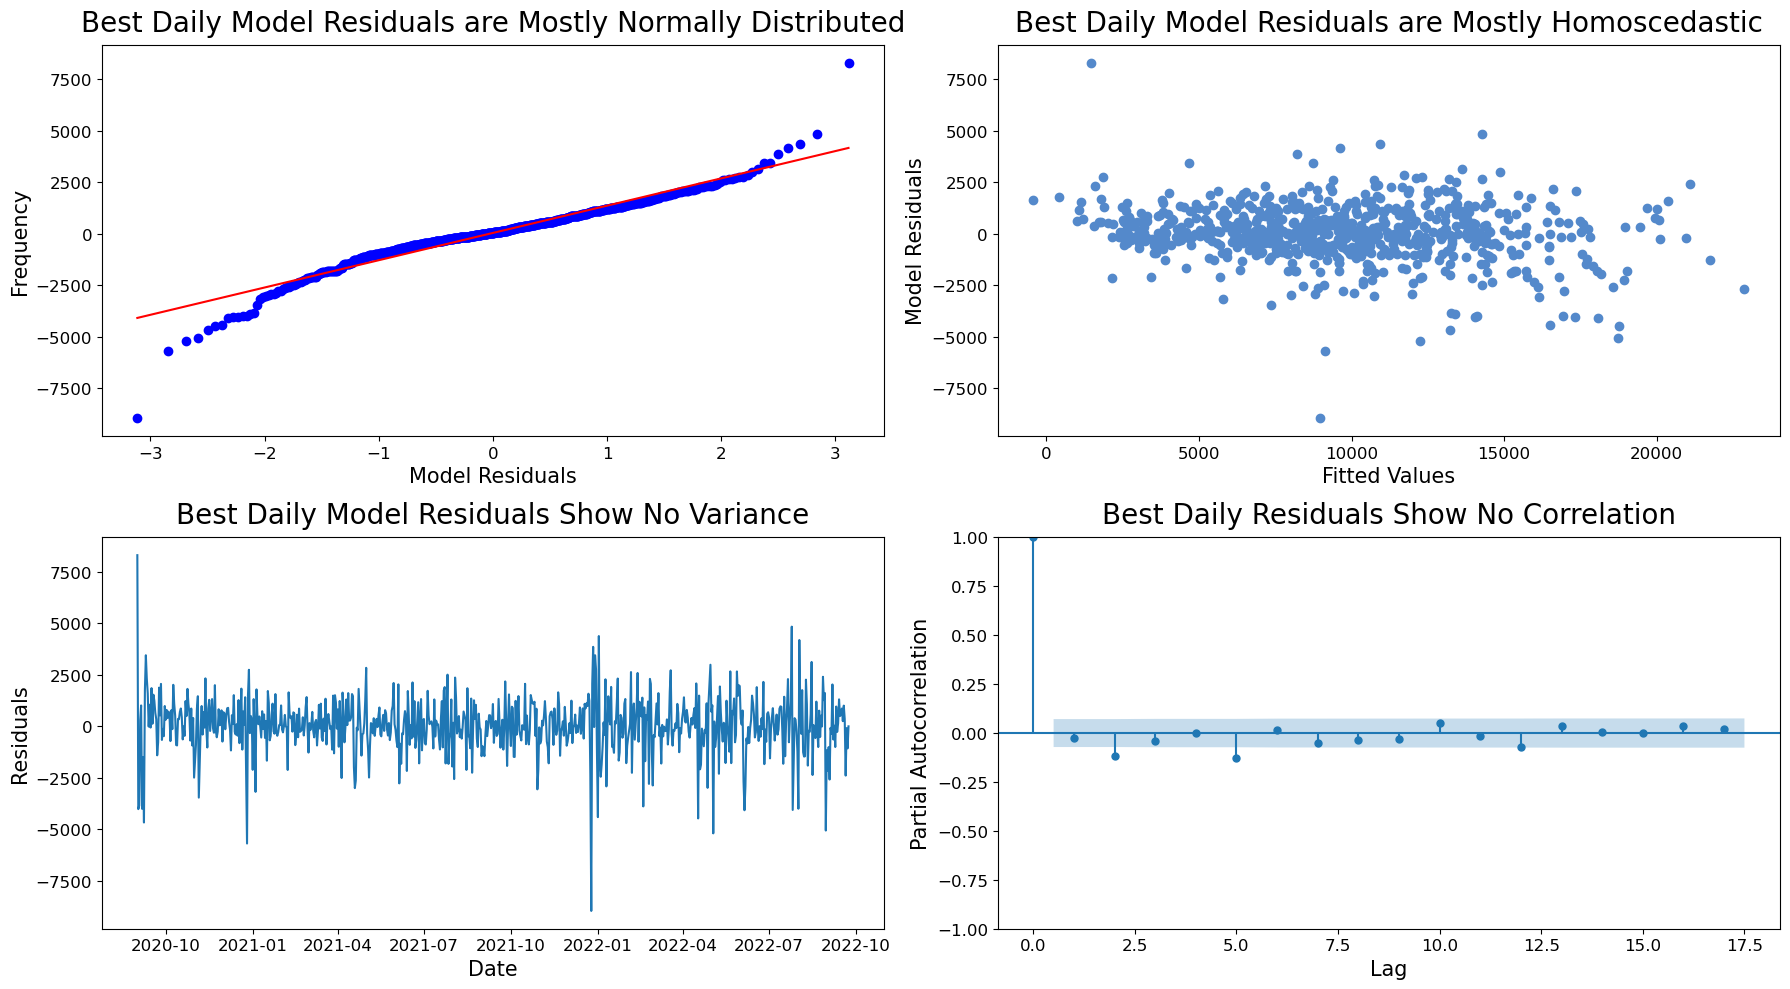

In [128]:
bakery.plot_residuals(model_resids, model_fittedvals, 'Best Daily Model Residuals are Mostly Normally Distributed', 
               'Best Daily Model Residuals are Mostly Homoscedastic', 
               'Best Daily Model Residuals Show No Variance', 'Best Daily Residuals Show No Correlation')

## Daily Model Evaluation 
It can be seen from all the above plots that:
- The residuals are normally distributed 
- The fitted values vs residuals are mostly homoscedastic, with the slightest fan shape. However, this is not deemed significant and therefore the model assumptions are met
- There is no correlation between residuals

---

# 2. Weekly Revenue Forecast
## Selecting Baseline Parameters 
First the original weekly data and differenced data will be visualised to see if the data becomes stationary and then the `Dickey-Fuller Test` can be run to confirm that it is. 

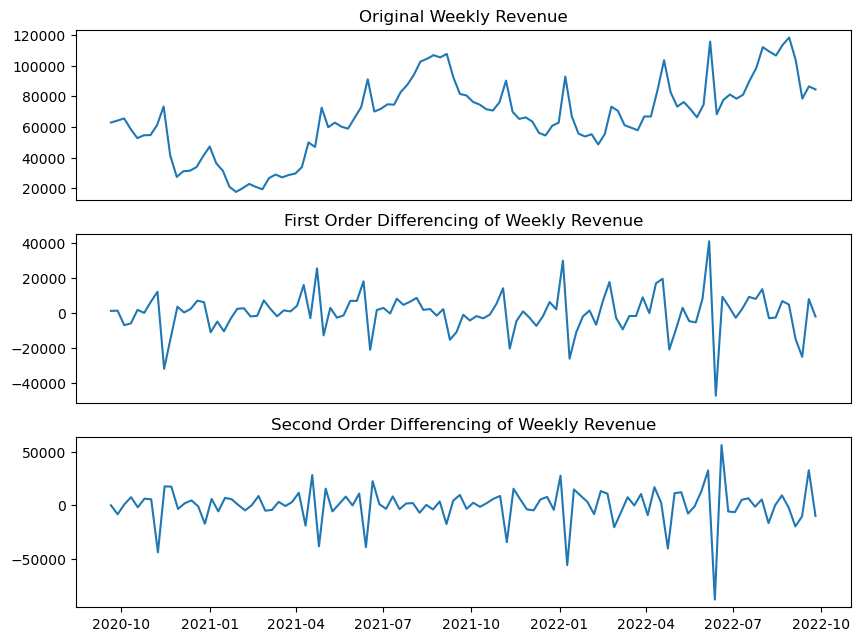

In [129]:
# Subplots of orginal and differenced daily data 
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(total_rev_weekly['Total_Revenue']); ax1.set_title('Original Weekly Revenue'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(total_rev_weekly['Total_Revenue'].diff()); ax2.set_title('First Order Differencing of Weekly Revenue'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(total_rev_weekly['Total_Revenue'].diff().diff()); ax3.set_title('Second Order Differencing of Weekly Revenue')
plt.show()

**Observations**: The first order differencing appears to be more stationary than the second. This will be confirmed with the `Dickey-Fuller Test`.

In [130]:
#perform augmented Dickey-Fuller test
adfuller(total_rev_weekly['Total_Revenue'].diff().dropna())

(-11.98616528236147,
 3.609012339190467e-22,
 0,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 2006.8166111418727)

**Dickey-Fuller Test Output**

|Revenue| Test Statistic | p-value |
|:--| :- | :- | 
|Daily|-11.986| 3.609 *e*<sup>-11</sup>|

The p-value is less than 0.05, therefore can reject the null hypothesis that the time series is non-stationary. Therefore, the `d parameter` for the baseline model shall be 1. 

---

## Determining the `p` and `q` Parameters for Weelky Baseline
Autocorrelation plots help determine if the successive elements of a time series are positively correlated, negatively correlated, or independent of each other. Analysing the autocorrelations is a key step in finding the right `p` and `q` parameters for (autoregressive) time series models.

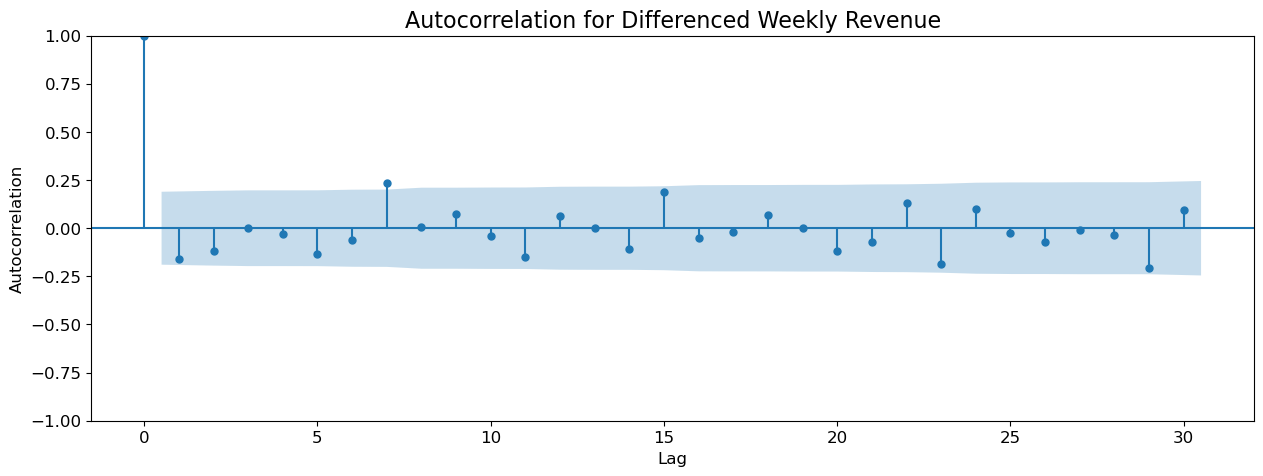

In [131]:
# Plotting the autocorrelation of the differenced data 
plt.figure(figsize=(15, 5))
plot_acf(total_rev_weekly['Total_Revenue'].diff().dropna(), lags=30, ax=plt.gca())
plt.ylabel('Autocorrelation', fontsize=12)
plt.xlabel('Lag', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Autocorrelation for Differenced Weekly Revenue', fontsize=16)
plt.show()

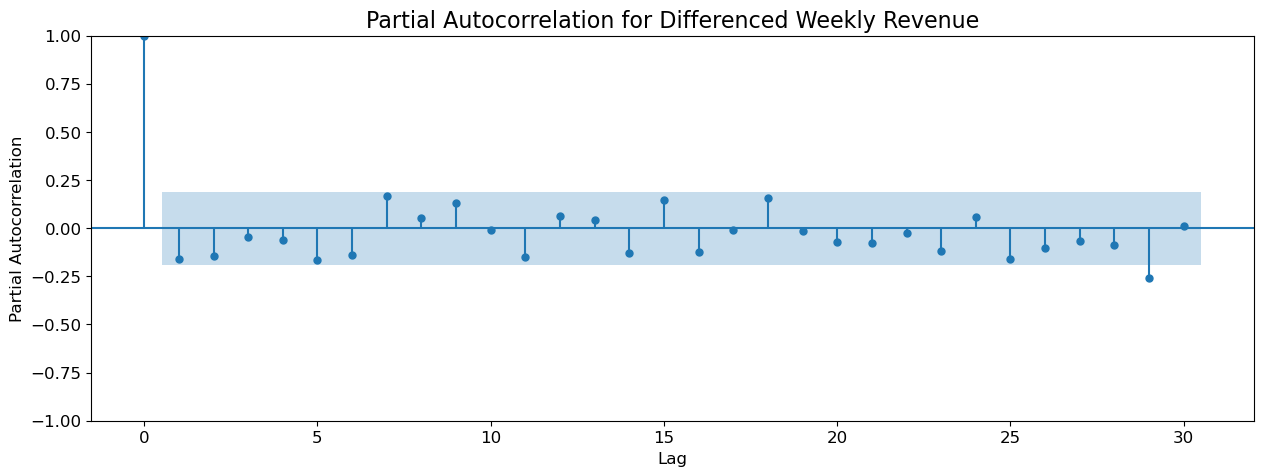

In [132]:
# To plot the partial autocorrelation of differenced data 
plt.figure(figsize=(15, 5))
plot_pacf(total_rev_weekly['Total_Revenue'].diff().dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Partial Autocorrelation', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Partial Autocorrelation for Differenced Weekly Revenue', fontsize=16)
plt.show()

## ACF and PACF Observations
Picking the right order parameter `p` and `q` , should include all or most of the significant correlations in the PACF plot.
- From the PACF plot it can be seen that `p = 3` for the daily baseline model

- From the ACF plot, it can be determined that for the baseline model `q = 1`. 

---

# Model 1 - Baseline Weekly Model
From the above differencing, ACF and PACF plots it is determined that the hyperparameters are:
- p = 0
- d = 1
- q = 0

**Splitting the Series for Modelling**

First the data is split into train and test sets as determined by the business, which is to predict the next 6 weeks of revenue.

*Therefore, anything on or before the date 19-08-2022 is train and post is test data.*

In [133]:
# Splitting the train and test data
train_weekly = pd.DataFrame(total_rev_weekly.loc[total_rev_weekly.index <= '2022-08-19', 'Total_Revenue'].copy())
test_weekly = pd.DataFrame(total_rev_weekly.loc[total_rev_weekly.index > '2022-08-19', 'Total_Revenue'].copy())

In [134]:
# First an empty results dataframe is created to track the accuracy of the models run
weekly_model_scores = pd.DataFrame()

In [135]:
p_param = 0
d_param = 1
q_param = 0

model = SARIMAX(train_weekly, order=(p_param, d_param, q_param), seasonal_order = (0, 1, 0, 52), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Total_Revenue   No. Observations:                  102
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -522.043
Date:                            Thu, 03 Nov 2022   AIC                           1048.086
Time:                                    20:43:57   BIC                           1051.870
Sample:                                09-06-2020   HQIC                          1049.522
                                     - 08-14-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -605.3694   1598.377     -0.379      0.705   -3738.132    2527.393
sigma2      1.051e+08   1.61e+07      6.530      0.000    7.35e+07    1.37e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):                14.87
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                             0.82
Prob(H) (two-sided):                  0.13   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
predictions_1 = model_fit.predict(start=0, end=len(train_weekly)+len(test_weekly)-1)

In [137]:
bakery.train_forecast_plot(train_weekly,test_weekly, predictions_1, 'Model 1 - Baseline Weekly Forecast')

In [138]:
bakery.full_accuracy_report(test_weekly, predictions_1[test_weekly.index], 'weekly forecast')

The R2 for the weekly forecast is: 0.539

The RMSE for the weekly forecast is: 10279.7

The MAE between the actual and weekly forecast revenue is 9334.52

The MAPE between the actual and weekly forecast revenue is 9.4%


## Model 1 Weekly Accuracy Evaluation 
The baseline model has produced a model with a MAPE accuracy score of 9.4%, which is already better than the Moving Average and Linear Regression models. 

Following the daily model process, the weekly data will be passed through the grid search to tune the hyperparameters.

In [139]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 1, 0.539, 10279.7, 1048.086, '9.4%',
                                  'p=0, d=1, q=0')

Model     R2     RMSE       AIC MAPE (%)       Comments
0      1  0.539  10279.7  1048.086     9.4%  p=0, d=1, q=0

# SARIMAX Grid Search to Tune Hyperparameters 
The `evaluate_models` and `evaluate_sarimax_model` functions are used to tune the hyperparameters for the weekly forecast.

**N.B** *The grid search has been commented out to reduce run time of the notebook. An image of the results can be found in the below code cell.*

In [140]:
# # evaluate parameters
# p_values = [0, 1, 2, 4, 6, 8]
# d_values = range(0, 3)
# q_values = range(0, 3)
# s_range = range(0,2)
# warnings.filterwarnings("ignore")
# bakery.evaluate_models(train_weekly.values, p_values, d_values, q_values, None, s_range, 52, 0.9)

*Image of the results from the above grid search*
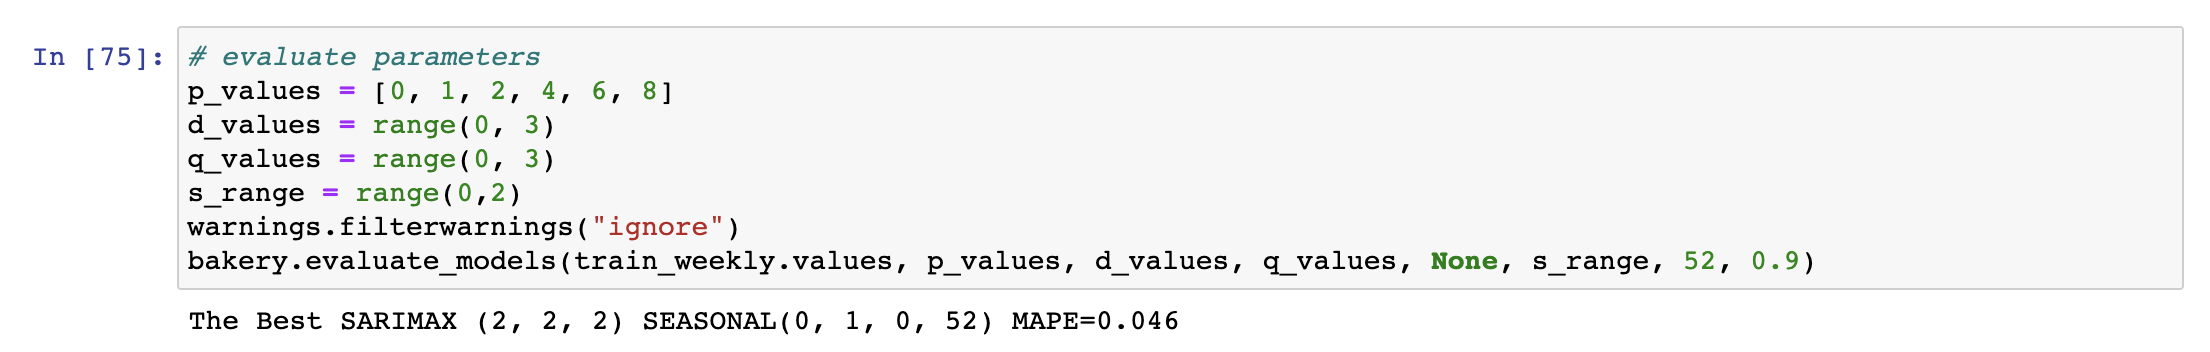

# Model 2 - Weekly Forecast Using Tuned Hyperparameters
The weekly model will be fitted again using the hyperparameters from the Grid Search. 

In [141]:
p_param = 2
d_param = 2
q_param = 2

model = SARIMAX(train_weekly, order=(p_param, d_param, q_param), seasonal_order = (0, 1, 0, 52), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Total_Revenue   No. Observations:                  102
Model:             SARIMAX(2, 2, 2)x(0, 1, [], 52)   Log Likelihood                -511.977
Date:                             Thu, 03 Nov 2022   AIC                           1035.954
Time:                                     20:43:59   BIC                           1047.181
Sample:                                 09-06-2020   HQIC                          1040.197
                                      - 08-14-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     87.4416    231.985      0.377      0.706    -367.241     542.124
ar.L1         -1.0087      0.178     -5.677      0.000      -1.357      -0.660
ar.L2         -0.0087      0.190     -0.046      0.963      -0.381       0.364
ma.L1         -0.0347      0.212     -0.164      0.870      -0.450       0.380
ma.L2         -0.9653      0.256     -3.769      0.000      -1.467      -0.463
sigma2      1.291e+08   3.34e-09   3.86e+16      0.000    1.29e+08    1.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                10.73
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             0.73
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.45e+37. Standard errors may be unstable.
"""

In [142]:
predictions_2 = model_fit.predict(start=0, end=len(train_weekly)+len(test_weekly)-1)

In [143]:
bakery.train_forecast_plot(train_weekly,test_weekly, predictions_2, 'Model 2 - Weekly Forecast with Tuned Parameters')

In [144]:
bakery.full_accuracy_report(test_weekly, predictions_2[test_weekly.index], 'weekly forecast')

The R2 for the weekly forecast is: 0.57

The RMSE for the weekly forecast is: 9928.3

The MAE between the actual and weekly forecast revenue is 9311.25

The MAPE between the actual and weekly forecast revenue is 9.3%


## Model 2 Weekly Accuracy Evaluation 
Using the tuned hyperparameters increased the accuracy of the models, achieving a MAPE score of 9.3%. 

As with the daily forecast, the special dates will be added to the model. This is thought to improve the model as it did with the daily forecast. 

In [145]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 2, 0.57, 9928.3, 1035.954, '9.3%',
                                  'p=2,q=2,d=2')

Model     R2     RMSE       AIC MAPE (%)       Comments
0      1  0.539  10279.7  1048.086     9.4%  p=0, d=1, q=0
1      2  0.570   9928.3  1035.954     9.3%    p=2,q=2,d=2

# Model 3 - Baseline Weekly Forecast With Special Dates
As with the daily forecast, special dates will be added in the SARIMAX model to see if this improves the accuracy. First the special dates need to be resampled to be the same index as the weekly forecast and the values summed. 

In [146]:
# Splitting the train and test data
special_days = total_rev[['Bank_Holiday','Closed_Xmas','School_Holiday','Weekday','Weekend']].copy()
special_days = special_days.resample('W').sum()
special_days = special_days[:(len(special_days)-1)]
train_ex = special_days.loc[special_days.index <= '2022-08-14'].copy()
test_ex = special_days.loc[special_days.index > '2022-08-14'].copy()

In [147]:
# Baseline model run with the original baseline hyperparameters 
p_param = 0
d_param = 1
q_param = 0

model = SARIMAX(train_weekly, exog=train_ex, 
                order=(p_param, d_param, q_param), seasonal_order = (0, 1, 0, 52), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Total_Revenue   No. Observations:                  102
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -504.145
Date:                            Thu, 03 Nov 2022   AIC                           1022.290
Time:                                    20:43:59   BIC                           1035.533
Sample:                                09-06-2020   HQIC                          1027.314
                                     - 08-14-2022                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       -358.6439   1052.014     -0.341      0.733   -2420.554    1703.266
Bank_Holiday    1.861e+04   1.42e+05      0.131      0.896    -2.6e+05    2.98e+05
Closed_Xmas    -3.693e-13   7.51e-05  -4.92e-09      1.000      -0.000       0.000
School_Holiday  5839.7876   1.42e+05      0.041      0.967   -2.73e+05    2.85e+05
Weekday         9097.9195   1.42e+05      0.064      0.949    -2.7e+05    2.88e+05
Weekend         3008.9403   1.42e+05      0.021      0.983   -2.76e+05    2.82e+05
sigma2           5.06e+07   1.33e+07      3.812      0.000    2.46e+07    7.66e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 0.95
Prob(Q):                              0.63   Prob(JB):                         0.62
Heteroskedasticity (H):               1.06   Skew:                             0.05
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.03e+24. Standard errors may be unstable.
"""

In [148]:
predictions_3 = model_fit.predict(start=0, end=len(train_weekly)+len(test_weekly)-1, exog=test_ex)

In [149]:
bakery.train_forecast_plot(train_weekly, test_weekly, predictions_3, 'Model 3 - Baseline Model Adding Special Days')

In [150]:
bakery.full_accuracy_report(test_weekly, predictions_3[test_weekly.index], 'weekly forecast with special days')

The R2 for the weekly forecast with special days is: 0.587

The RMSE for the weekly forecast with special days is: 9729.06

The MAE between the actual and weekly forecast with special days revenue is 8942.37

The MAPE between the actual and weekly forecast with special days revenue is 9.0%


## Model 3 Weekly Accuracy Evaluation 
By adding the exogenous data of the special dates, this did improve the accuracy of the model, lowering the MAPE score to 9.0%. It also imporved the R<sup>2</sup>, RMSE and AIC scores. 

As this is just the baseline model, the new train data with the exogenous data will be run through the grid search in an attempt to improve the score. 

In [151]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 3, 0.587, 9729.06, 1022.290, '9.0%',
                                  'p=1,q=0,d=1, special dates added')

Model     R2      RMSE       AIC MAPE (%)                          Comments
0      1  0.539  10279.70  1048.086     9.4%                     p=0, d=1, q=0
1      2  0.570   9928.30  1035.954     9.3%                       p=2,q=2,d=2
2      3  0.587   9729.06  1022.290     9.0%  p=1,q=0,d=1, special dates added

# Model 4 - Tuning Hyperparameters with Speical Dates
**N.B** *The grid search has been commented out to reduce run time of the notebook. An image of the results can be found in the below code cell.*

In [152]:
# # evaluate parameters
# p_values = [0, 1, 2, 4, 6, 8]
# d_values = range(0, 3)
# q_values = range(0, 3)
# s_range = range(0,2)
# warnings.filterwarnings("ignore")
# bakery.evaluate_models(train_weekly.values, p_values, d_values, q_values, train_ex, s_range, 52, 0.9)

*Image of the results from the above grid search*
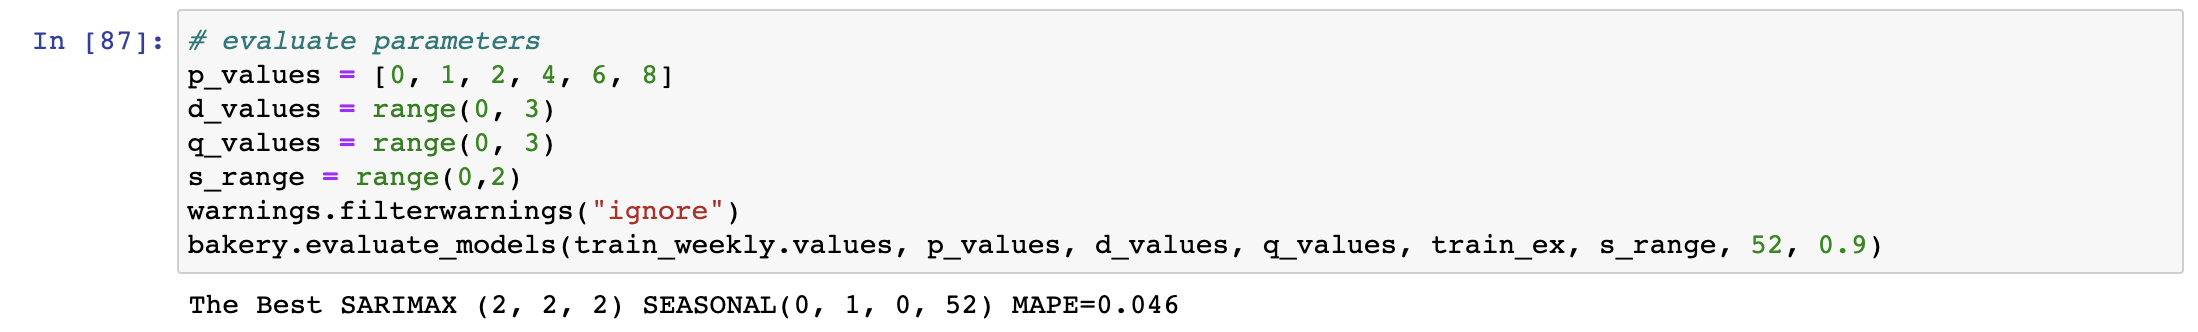

In [153]:
# Run with best hyperparameters
p_param = 2
d_param = 2
q_param = 2

model = SARIMAX(train_weekly, exog = train_ex, order=(p_param, d_param, q_param),
                seasonal_order = (0, 1, 0, 52), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Total_Revenue   No. Observations:                  102
Model:             SARIMAX(2, 2, 2)x(0, 1, [], 52)   Log Likelihood                -495.932
Date:                             Thu, 03 Nov 2022   AIC                           1013.863
Time:                                     20:44:03   BIC                           1034.446
Sample:                                 09-06-2020   HQIC                          1021.642
                                      - 08-14-2022                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         37.2233    203.068      0.183      0.855    -360.782     435.229
Bank_Holiday    1.507e+04   8594.786      1.753      0.080   -1777.836    3.19e+04
Closed_Xmas        0.0263     12.710      0.002      0.998     -24.885      24.937
School_Holiday  3077.5137   8551.031      0.360      0.719   -1.37e+04    1.98e+04
Weekday         5768.2463   8632.302      0.668      0.504   -1.12e+04    2.27e+04
Weekend         -151.1718   8485.715     -0.018      0.986   -1.68e+04    1.65e+04
ar.L1             -0.8800      0.176     -5.003      0.000      -1.225      -0.535
ar.L2              0.1200      0.193      0.623      0.533      -0.258       0.498
ma.L1             -0.0246      0.329     -0.075      0.940      -0.670       0.621
ma.L2             -0.9728      0.316     -3.077      0.002      -1.593      -0.353
sigma2          5.438e+07      0.151   3.59e+08      0.000    5.44e+07    5.44e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.82   Prob(JB):                         0.72
Heteroskedasticity (H):               0.75   Skew:                            -0.15
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.43e+25. Standard errors may be unstable.
"""

In [154]:
predictions_4 = model_fit.predict(start=0, end=len(train_weekly)+len(test_weekly)-1, exog=test_ex)

In [155]:
bakery.train_forecast_plot(train_weekly, test_weekly, predictions_4, 
                           'Model 4 - Tuned Hyperparameters With Special Days')

In [156]:
bakery.full_accuracy_report(test_weekly, predictions_4[test_weekly.index], 'weekly forecast with special days')

The R2 for the weekly forecast with special days is: 0.466

The RMSE for the weekly forecast with special days is: 11068.52

The MAE between the actual and weekly forecast with special days revenue is 10114.64

The MAPE between the actual and weekly forecast with special days revenue is 10.1%


## Model 4 Weekly Accuracy Evaluation 
Using the hyperparameters from the grid search, this actually decreased the accuracy of the model and from the R<sup>2</sup> value it can be seen that the predicted values fit poorly to the actual values. 

Looking at the p-values of the model though a lot of them are above the threshold value of 0.05, therefore `Bank_Holiday` and `Weekday`, which have the greatest p-values will be removed from the next iteration. 

In [157]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 4, 0.466, 11068.52, 1013.863, '10.1%',
                                  'p=2,q=2,d=2')

Model     R2      RMSE       AIC MAPE (%)                          Comments
0      1  0.539  10279.70  1048.086     9.4%                     p=0, d=1, q=0
1      2  0.570   9928.30  1035.954     9.3%                       p=2,q=2,d=2
2      3  0.587   9729.06  1022.290     9.0%  p=1,q=0,d=1, special dates added
3      4  0.466  11068.52  1013.863    10.1%                       p=2,q=2,d=2

# Model 5 - Removing Variables with P-Values Greater than 0.05
The 2 variables with the greatest p-values will be removed, leaving only `Bank_Holiday` and `Weekday` as the independent variables.

In [158]:
# Splitting the train and test data
special_days_reduced = special_days[['Bank_Holiday','Weekday']].copy()
train_ex = special_days_reduced.loc[special_days_reduced.index <= '2022-08-19'].copy()
test_ex = special_days_reduced.loc[special_days_reduced.index > '2022-08-19'].copy()

In [159]:
# Re-run with reduced variables
p_param = 2
d_param = 2
q_param = 2

model = SARIMAX(train_weekly, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (0, 1, 0, 52), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Total_Revenue   No. Observations:                  102
Model:             SARIMAX(2, 2, 2)x(0, 1, [], 52)   Log Likelihood                -498.687
Date:                             Thu, 03 Nov 2022   AIC                           1013.374
Time:                                     20:44:06   BIC                           1028.344
Sample:                                 09-06-2020   HQIC                          1019.031
                                      - 08-14-2022                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       93.3838    165.875      0.563      0.573    -231.725     418.493
Bank_Holiday  1.199e+04   1587.585      7.555      0.000    8882.103    1.51e+04
Weekday       2126.3326    859.765      2.473      0.013     441.224    3811.441
ar.L1           -0.9151      0.175     -5.240      0.000      -1.257      -0.573
ar.L2            0.0849      0.190      0.446      0.656      -0.288       0.458
ma.L1           -0.0229      0.324     -0.071      0.944      -0.658       0.612
ma.L2           -0.9771      0.304     -3.211      0.001      -1.573      -0.381
sigma2        6.328e+07   1.98e-08    3.2e+15      0.000    6.33e+07    6.33e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.60   Prob(JB):                         0.57
Heteroskedasticity (H):               0.84   Skew:                            -0.31
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.81e+39. Standard errors may be unstable.
"""

In [160]:
predictions_5 = model_fit.predict(start=0, end=len(train_weekly)+len(test_weekly)-1, exog=test_ex)

In [161]:
bakery.train_forecast_plot(train_weekly, test_weekly, predictions_5, 'Model 5 - Reducing Variables')

In [162]:
bakery.full_accuracy_report(test_weekly, predictions_5[test_weekly.index], 'weekly forecast with reduced variables')

The R2 for the weekly forecast with reduced variables is: 0.513

The RMSE for the weekly forecast with reduced variables is: 10568.09

The MAE between the actual and weekly forecast with reduced variables revenue is 9574.39

The MAPE between the actual and weekly forecast with reduced variables revenue is 9.5%


## Model 5 Weekly Accuracy Evaluation 
Removing the two independent variables improved the accuracy of the model a bit, but it is still not as good as model 3. 

Again, looking at the p-values of the model, one of the autoregressive and moving average coefficients have p-values over the threshold of 0.05. Therefore, these will be reduced in the next iteration.  

In [163]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 5, 0.513, 10568.09, 1012.726, '9.5%',
                                  'Removing Weekend, School Hol and Xmas')

Model     R2      RMSE       AIC MAPE (%)  \
0      1  0.539  10279.70  1048.086     9.4%   
1      2  0.570   9928.30  1035.954     9.3%   
2      3  0.587   9729.06  1022.290     9.0%   
3      4  0.466  11068.52  1013.863    10.1%   
4      5  0.513  10568.09  1012.726     9.5%   

                                Comments  
0                          p=0, d=1, q=0  
1                            p=2,q=2,d=2  
2       p=1,q=0,d=1, special dates added  
3                            p=2,q=2,d=2  
4  Removing Weekend, School Hol and Xmas

# Model 6 - Reducing Hyperparameters with P-Value Over Than 0.05
One of the autoregressive and moving average coefficients have p-values greater than 0.05, suggesting they are not statistically significant. Therefore, the `p` and `q` parameters will both be reduced to 1. 

In [164]:
# Reducing p/q values
p_param = 1
d_param = 2
q_param = 1

model = SARIMAX(train_weekly, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (0, 1, 0, 52), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Total_Revenue   No. Observations:                  102
Model:             SARIMAX(1, 2, 1)x(0, 1, [], 52)   Log Likelihood                -500.363
Date:                             Thu, 03 Nov 2022   AIC                           1012.726
Time:                                     20:44:07   BIC                           1023.953
Sample:                                 09-06-2020   HQIC                          1016.969
                                      - 08-14-2022                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       47.3047    105.177      0.450      0.653    -158.838     253.448
Bank_Holiday    1.2e+04   2049.735      5.853      0.000    7980.009     1.6e+04
Weekday       2129.0315   1074.113      1.982      0.047      23.808    4234.254
ar.L1            0.0067      0.209      0.032      0.974      -0.403       0.416
ma.L1           -0.9894      0.381     -2.600      0.009      -1.735      -0.244
sigma2         8.72e+07      0.010   8.55e+09      0.000    8.72e+07    8.72e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 0.88
Prob(Q):                              0.62   Prob(JB):                         0.64
Heteroskedasticity (H):               0.93   Skew:                            -0.22
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.1e+26. Standard errors may be unstable.
"""

In [165]:
predictions_6 = model_fit.predict(start=0, end=len(train_weekly)+len(test_weekly)-1, exog=test_ex)

In [166]:
bakery.train_forecast_plot(train_weekly, test_weekly, predictions_6, 'Model 6 - Reducing Hyperparameters')

In [167]:
bakery.full_accuracy_report(test_weekly, predictions_6[test_weekly.index], 'Reduced parameters')

The R2 for the Reduced parameters is: 0.639

The RMSE for the Reduced parameters is: 9095.52

The MAE between the actual and Reduced parameters revenue is 8260.46

The MAPE between the actual and Reduced parameters revenue is 8.2%


## Model 6 Weekly Accuracy Evaluation 
Reducing the p and q hyperparameters has dramatically improved the MAPE score to 8.2% and increased the R<sup>2</sup> value. 

It can still be seen that the autoregressive coefficient has a p-value greater than 0.05, suggesting it is not statistically significant in the model. This will be reduced to 0 for the next iteration. 

In [168]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 6, 0.639, 9095.52, 1012.726, '8.2%',
                                  'Reducing hyperparameters')

Model     R2      RMSE       AIC MAPE (%)  \
0      1  0.539  10279.70  1048.086     9.4%   
1      2  0.570   9928.30  1035.954     9.3%   
2      3  0.587   9729.06  1022.290     9.0%   
3      4  0.466  11068.52  1013.863    10.1%   
4      5  0.513  10568.09  1012.726     9.5%   
5      6  0.639   9095.52  1012.726     8.2%   

                                Comments  
0                          p=0, d=1, q=0  
1                            p=2,q=2,d=2  
2       p=1,q=0,d=1, special dates added  
3                            p=2,q=2,d=2  
4  Removing Weekend, School Hol and Xmas  
5               Reducing hyperparameters

# Model 7 - Reducing Hyperparameters with P-Value Over Than 0.05
The autoregressive coefficients has a p-value greater than 0.05, suggesting it is not statistically significant. Therefore, the `p` parameter will both be reduced to 0. 

In [169]:
# Reducing p parameter values
p_param = 0
d_param = 2
q_param = 1

model = SARIMAX(train_weekly, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (0, 1, 0, 52), trend='c')
weekly_model_fit = model.fit(disp=0)

weekly_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Total_Revenue   No. Observations:                  102
Model:             SARIMAX(0, 2, 1)x(0, 1, [], 52)   Log Likelihood                -499.296
Date:                             Thu, 03 Nov 2022   AIC                           1008.592
Time:                                     20:44:08   BIC                           1017.948
Sample:                                 09-06-2020   HQIC                          1012.128
                                      - 08-14-2022                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       52.6858     65.405      0.806      0.421     -75.505     180.876
Bank_Holiday  1.212e+04   1514.938      7.999      0.000    9148.741    1.51e+04
Weekday       2675.4106    689.241      3.882      0.000    1324.522    4026.299
ma.L1           -0.9966      0.299     -3.333      0.001      -1.583      -0.411
sigma2        6.597e+07      0.001   1.16e+11      0.000     6.6e+07     6.6e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.64   Prob(JB):                         0.46
Heteroskedasticity (H):               0.95   Skew:                            -0.21
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.49e+28. Standard errors may be unstable.
"""

In [170]:
predictions_7 = model_fit.predict(start=0, end=len(train_weekly)+len(test_weekly)-1, exog=test_ex)

In [171]:
bakery.train_forecast_plot(train_weekly, test_weekly, predictions_7, 'Model 7 - Reducing Hyperparameters')

In [172]:
bakery.full_accuracy_report(test_weekly, predictions_7[test_weekly.index], 'Reduced parameters')

The R2 for the Reduced parameters is: 0.639

The RMSE for the Reduced parameters is: 9095.52

The MAE between the actual and Reduced parameters revenue is 8260.46

The MAPE between the actual and Reduced parameters revenue is 8.2%


## Model 7 Weekly Accuracy Evaluation 
The MAPE score did not improve from this iteration, however by removing the autoregressive component the p-values are now all below the threshold value, suggesting they are statistically signiciant and therefore an accurate model.

In [173]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 7, 0.633, 9169.81, 1008.592, '8.2%',
                                  'Reducing hyperparameters')

Model     R2      RMSE       AIC MAPE (%)  \
0      1  0.539  10279.70  1048.086     9.4%   
1      2  0.570   9928.30  1035.954     9.3%   
2      3  0.587   9729.06  1022.290     9.0%   
3      4  0.466  11068.52  1013.863    10.1%   
4      5  0.513  10568.09  1012.726     9.5%   
5      6  0.639   9095.52  1012.726     8.2%   
6      7  0.633   9169.81  1008.592     8.2%   

                                Comments  
0                          p=0, d=1, q=0  
1                            p=2,q=2,d=2  
2       p=1,q=0,d=1, special dates added  
3                            p=2,q=2,d=2  
4  Removing Weekend, School Hol and Xmas  
5               Reducing hyperparameters  
6               Reducing hyperparameters

---

# Weekly Revenue Model Results Discussion 
Of the 7 models that were run, model 7 produced the lowest AIC and MAPE scores, therefore is deemed the most accurate model for the weekly forecast. Model 6 is a close second, however it has a greater AIC score. 

The SARIMAX best weekly model also scored the lowest accuracy scores compared to the moving average and linear regression models, making it the most accurate model so far for predicting weekly revenue. 

However, despite achieving the lowest MAPE score, it can be seen in the graphs of the actual versus predicted revenue that the predicted values are quite sporadic and don't fit well to the true values very well, with the highest R<sup>2</sup> value being c.0.64. Whilst this does not mean the model will be poor at predicting values, it is something to keep in mind that could be an issue in future predictions. To assess whether this will be an issue the model should be run on more test data. 

This model will be saved to a `pkl` object to be re-called in the Modelling Summary for comparison. 

In [174]:
# To save the daily model 
joblib.dump(weekly_model_fit, 'sarimax_weekly_model.pkl') 

['sarimax_weekly_model.pkl']

In [175]:
# To validate it saved correctly the same summary as for model 7 should be displayed 
weekly_model_test = joblib.load('sarimax_weekly_model.pkl') 
display(weekly_model_test.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Total_Revenue   No. Observations:                  102
Model:             SARIMAX(0, 2, 1)x(0, 1, [], 52)   Log Likelihood                -499.296
Date:                             Thu, 03 Nov 2022   AIC                           1008.592
Time:                                     20:44:09   BIC                           1017.948
Sample:                                 09-06-2020   HQIC                          1012.128
                                      - 08-14-2022                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       52.6858     65.405      0.806      0.421     -75.505     180.876
Bank_Holiday  1.212e+04   1514.938      7.999      0.000    9148.741    1.51e+04
Weekday       2675.4106    689.241      3.882      0.000    1324.522    4026.299
ma.L1           -0.9966      0.299     -3.333      0.001      -1.583      -0.411
sigma2        6.597e+07      0.001   1.16e+11      0.000     6.6e+07     6.6e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.64   Prob(JB):                         0.46
Heteroskedasticity (H):               0.95   Skew:                            -0.21
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.49e+28. Standard errors may be unstable.
"""

#  Exploring Reisudals of Best Weekly Model
To further evaluate the best models performance, the model residuals will be explored. For an accurate linear model, the assumptions are that: 
- Residuals are normally distributed
- Homoscedasticity: Variance of error terms are similar across the values of the independent variables
- The ACF of the residuals should show no significant correlations - this can be tested by a Box-Pierce test

In [176]:
model_resids = weekly_model_fit.resid
model_fitted = weekly_model_fit.fittedvalues

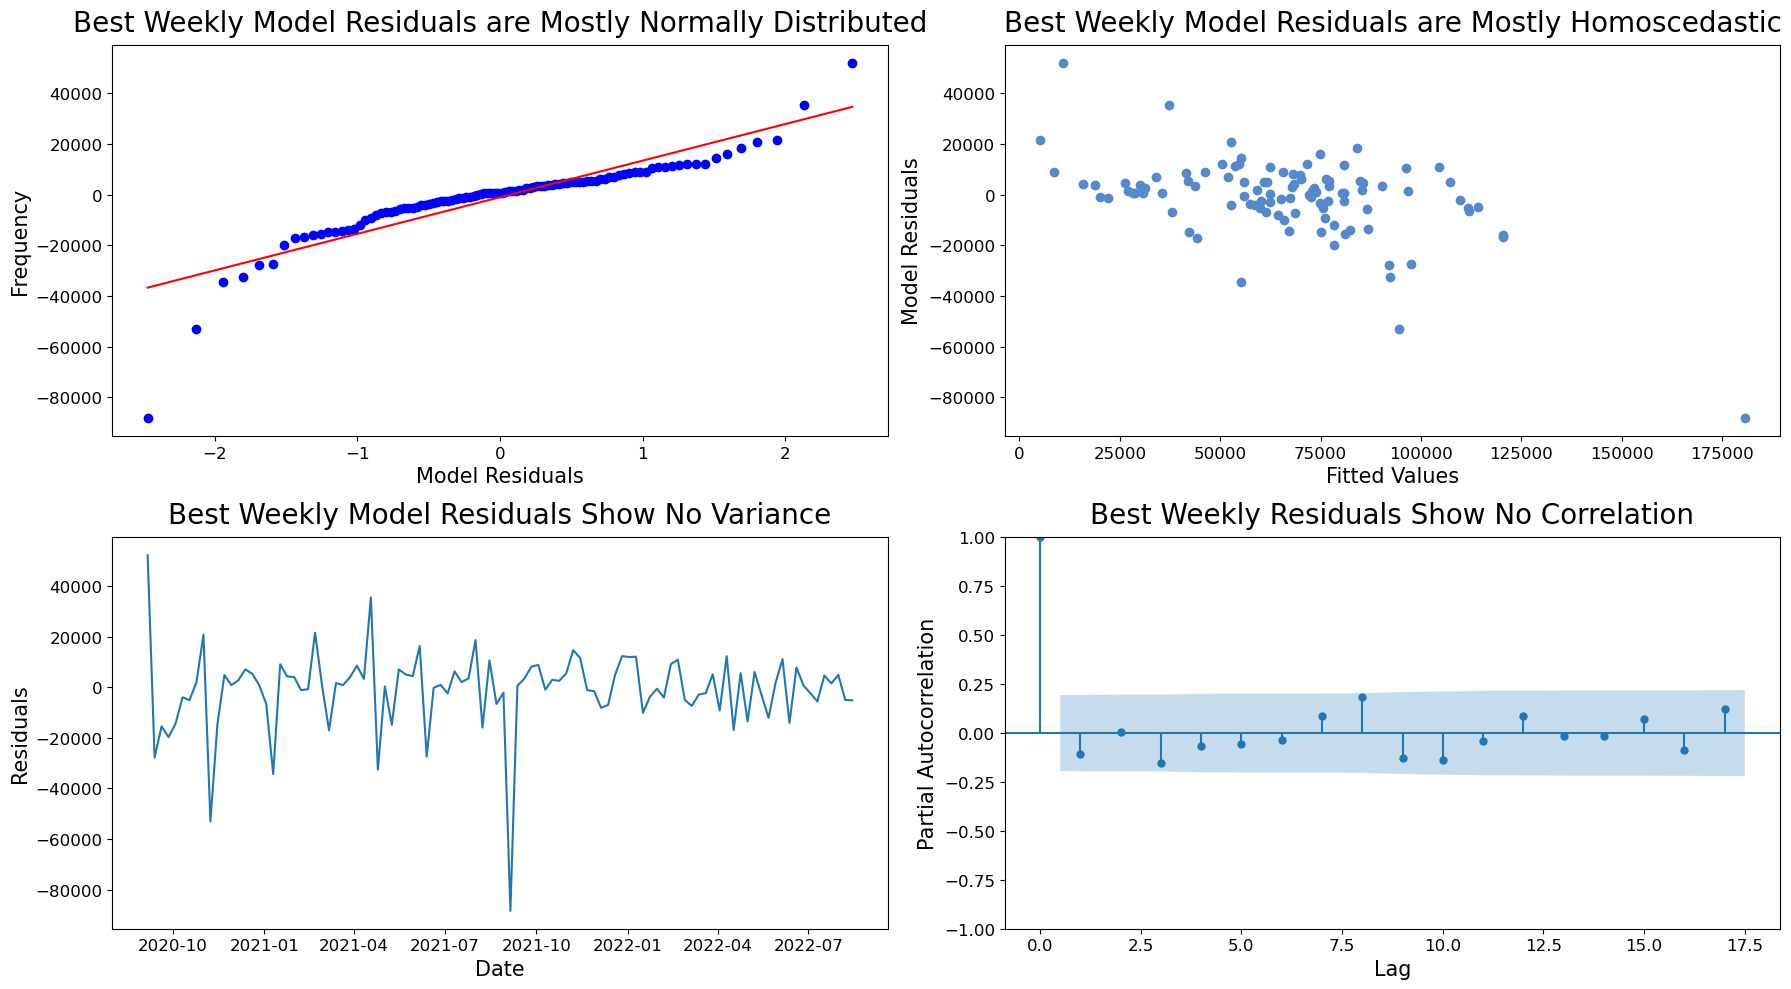

In [177]:
bakery.plot_residuals(model_resids, model_fitted, 'Best Weekly Model Residuals are Mostly Normally Distributed', 
               'Best Weekly Model Residuals are Mostly Homoscedastic', 
               'Best Weekly Model Residuals Show No Variance', 'Best Weekly Residuals Show No Correlation')

## Weekly Model Evaluation 

- From the ACF plot and the model residuals vs fitted values it can be seen that there is little variance and no correlation between residuals. 
- The residuals are also mostly normally distributed, with a slight left hand skew. 
- The fitted values are mostly homoscedastic (meaning the errors are mostly random), except for one outlier predicted value, which by reveiewing the forecast versus predicted values plot for model 7 can be seen is most liekly due to either the first data point or the large peak on September 5th 2022. 

---

# 3. Monthly Revenue Forecast
## Selecting Baseline Parameters 
First the original weekly data and differenced data will be visualised to see if the data becomes stationary and then the `Dickey-Fuller Test` can be run to confirm that it is. 

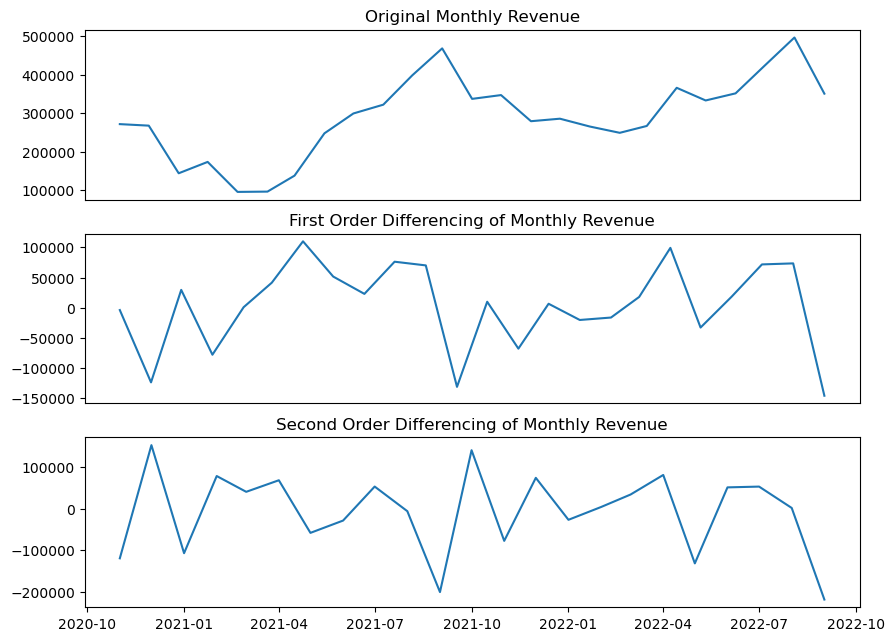

In [178]:
# Subplots of orginal and differenced daily data 
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(total_rev_monthly['Total_Revenue']); ax1.set_title('Original Monthly Revenue'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(total_rev_monthly['Total_Revenue'].diff()); ax2.set_title('First Order Differencing of Monthly Revenue'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(total_rev_monthly['Total_Revenue'].diff().diff()); ax3.set_title('Second Order Differencing of Monthly Revenue')
plt.show()

**Observations**: The first order differencing appears to be more stationary than the second. This will be confirmed with the `Dickey-Fuller Test`.

In [179]:
# To perform augmented Dickey-Fuller test on first order difference
adfuller(total_rev_monthly['Total_Revenue'].diff().dropna())

(-4.584943825120743,
 0.0001376800000181706,
 6,
 17,
 {'1%': -3.889265672705068,
  '5%': -3.0543579727254224,
  '10%': -2.66698384083045},
 348.1710803431318)

**Dickey-Fuller Test Output**

|Revenue| Test Statistic | p-value |
|:--| :- | :- | 
|Daily|-4.585| 0.00014|

The p-value is less than 0.05, therefore can reject the null hypothesis that the time series is non-stationary. Therefore, the `d parameter` for the baseline model shall be 1. 

---

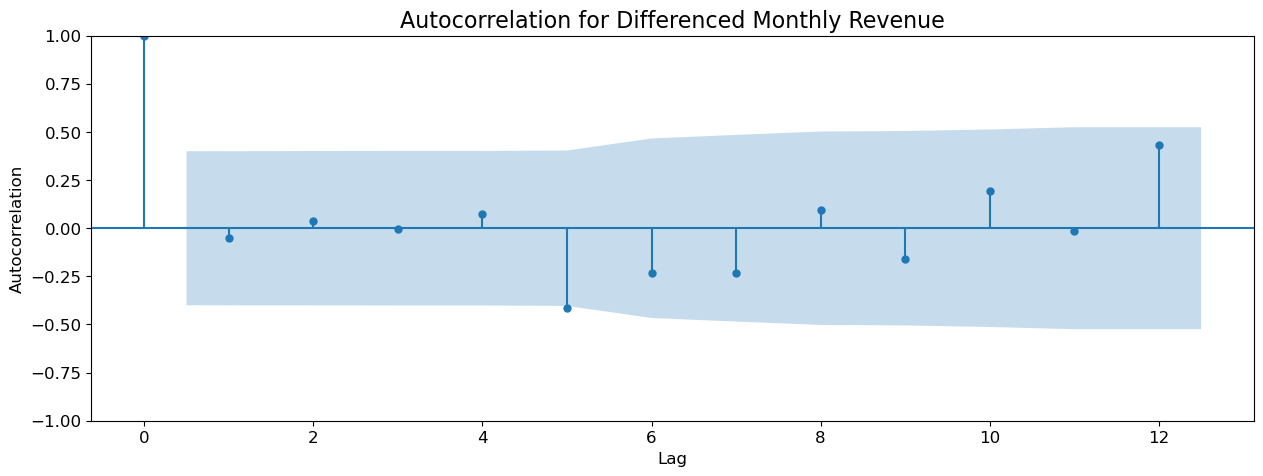

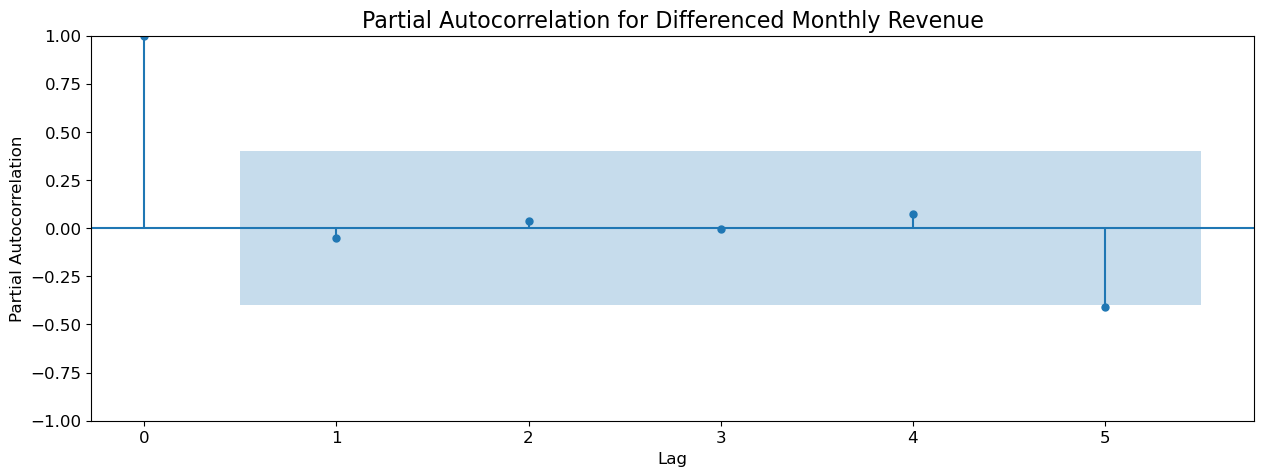

In [180]:
# Plotting the autocorrelation of the differenced data 
plt.figure(figsize=(15, 5))
plot_acf(total_rev_monthly['Total_Revenue'].diff().dropna(), lags=12, ax=plt.gca())
plt.ylabel('Autocorrelation', fontsize=12)
plt.xlabel('Lag', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Autocorrelation for Differenced Monthly Revenue', fontsize=16)
plt.show()

# To plot the partial autocorrelation of differenced data 
plt.figure(figsize=(15, 5))
plot_pacf(total_rev_monthly['Total_Revenue'].diff().dropna(), lags=5, ax=plt.gca(), method='ywm')
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Partial Autocorrelation', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Partial Autocorrelation for Differenced Monthly Revenue', fontsize=16)
plt.show()

## ACF and PACF Observations
Picking the right order parameter `p` and `q` , should include all or most of the significant correlations in the PACF plot.
- From the PACF plot it can be seen that `p = 0` for the daily baseline model

- From the ACF plot, it can be determined that for the baseline model `q = 0`. 
or 1 and 1

# Model 1 - Baseline Monthly Model
From the above differencing, ACF and PACF plots it is determined that the hyperparameters are:
- p = 3
- d = 2
- q = 1

In [181]:
# Splitting the train and test data
train_monthly = pd.DataFrame(total_rev_monthly.loc[total_rev_monthly.index <= '2022-03-01', 'Total_Revenue'].copy())
test_monthly = pd.DataFrame(total_rev_monthly.loc[total_rev_monthly.index > '2022-03-01', 'Total_Revenue'].copy())

In [182]:
# First an empty results dataframe is created to track the accuracy of the models run
monthly_model_scores = pd.DataFrame()

In [183]:
# Baseline model run 
p_param = 0
d_param = 1
q_param = 0

model = SARIMAX(train_monthly, order=(p_param, d_param, q_param), seasonal_order = (0, 0, 0, 12), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Total_Revenue   No. Observations:                   19
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -224.643
Date:                Thu, 03 Nov 2022   AIC                            453.287
Time:                        20:44:09   BIC                            455.068
Sample:                    09-01-2020   HQIC                           453.532
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -264.6989   1.65e+04     -0.016      0.987   -3.26e+04    3.21e+04
sigma2      4.052e+09    1.6e+09      2.525      0.012    9.07e+08     7.2e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.95
Prob(Q):                              0.93   Prob(JB):                         0.62
Heteroskedasticity (H):               0.24   Skew:                            -0.54
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [184]:
predictions_1 = model_fit.predict(start=0, end=len(train_monthly)+len(test_monthly)-1)

In [185]:
bakery.train_forecast_plot(train_monthly, test_monthly, predictions_1, 'Model 1 - Baseline Monthly Forecast')

In [186]:
bakery.full_accuracy_report(test_monthly, predictions_1[test_monthly.index], 'monthly forecast')

The R2 for the monthly forecast is: -4.565

The RMSE for the monthly forecast is: 133669.38

The MAE between the actual and monthly forecast revenue is 120976.07

The MAPE between the actual and monthly forecast revenue is 30.0%


## Model 1 Monthly Accuracy Evaluation 
The baseline monthly forecast produced very inaccurate results with an negative R<sup>2</sup> value and a MAPE score of 30%, which is worse than Linear Regression and Moving Average models. 

The monthly data will be passed through the grid search to try and improve the accuracy score.

In [187]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 1, -4.565, 133669.38, 1008.592, '30.0%',
                                  'Baseline, p=0, d=1, q=0')

Model     R2       RMSE       AIC MAPE (%)                 Comments
0      1 -4.565  133669.38  1008.592    30.0%  Baseline, p=0, d=1, q=0

# SARIMAX Grid Search to Tune Hyperparameters 
The `evaluate_models` and `evaluate_sarimax_model` functions are used to tune the hyperparameters for the monthly forecast.

**N.B** *The grid search has been commented out to reduce run time of the notebook. An image of the results can be found in the below code cell.*

In [188]:
# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 3)
s_range = range(0,2)
warnings.filterwarnings("ignore")
bakery.evaluate_models(train_monthly.values, p_values, d_values, q_values, None, s_range, 12, 0.9)

The Best SARIMAX (3, 1, 2) SEASONAL(1, 0, 1, 12) MAPE=0.005


*Image of the results from the above grid search* 
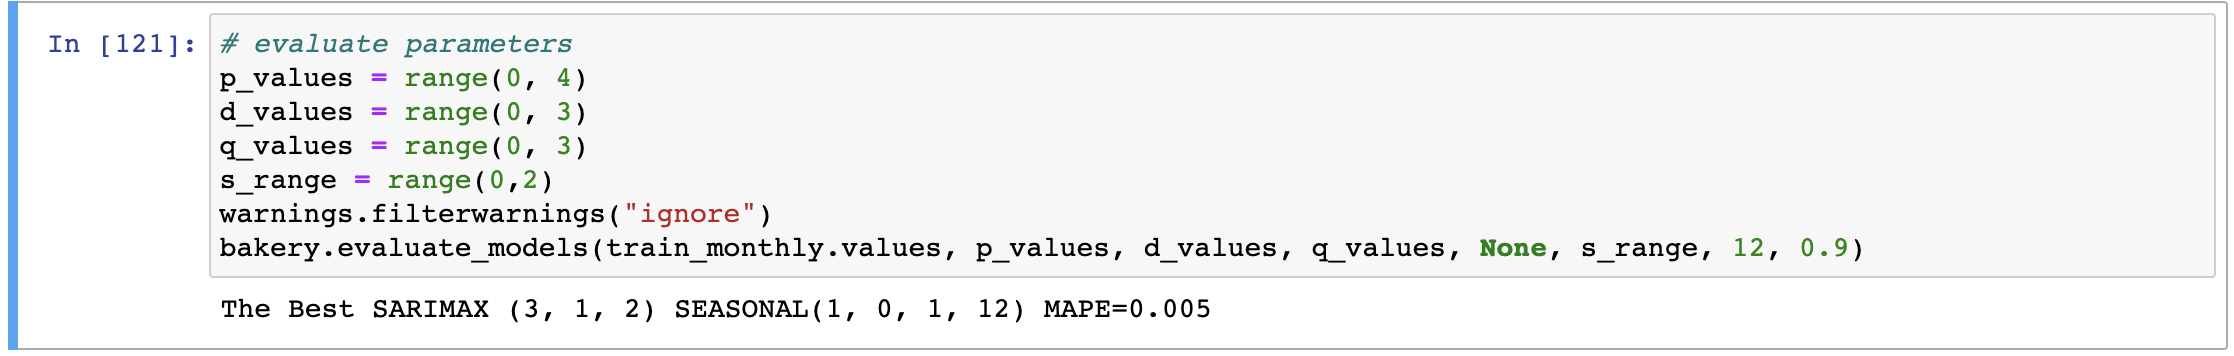

# Model 2 - Monthly Forecast with Tuned Hyperparameters

In [189]:
# Re-run with the best hyperparameters
p_param = 3
d_param = 1
q_param = 2

model= SARIMAX(train_monthly, order=(p_param, d_param, q_param), seasonal_order = (1, 0, 1, 12), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        Total_Revenue   No. Observations:                   19
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -222.625
Date:                              Thu, 03 Nov 2022   AIC                            463.250
Time:                                      20:44:29   BIC                            471.264
Sample:                                  09-01-2020   HQIC                           464.355
                                       - 03-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.176e+04   5.81e+05      0.020      0.984   -1.13e+06    1.15e+06
ar.L1         -0.1654      0.787     -0.210      0.834      -1.709       1.378
ar.L2          0.6517      0.641      1.016      0.309      -0.605       1.908
ar.L3         -0.1263      0.347     -0.364      0.716      -0.806       0.554
ma.L1          0.0120     69.022      0.000      1.000    -135.270     135.294
ma.L2         -0.9878     73.273     -0.013      0.989    -144.601     142.625
ar.S.L12      -0.9463     93.577     -0.010      0.992    -184.353     182.461
ma.S.L12       0.8168    168.864      0.005      0.996    -330.150     331.784
sigma2      2.673e+09      0.062    4.3e+10      0.000    2.67e+09    2.67e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.78   Prob(JB):                         0.66
Heteroskedasticity (H):               0.97   Skew:                            -0.08
Prob(H) (two-sided):                  0.97   Kurtosis:                         1.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.24e+30. Standard errors may be unstable.
"""

In [190]:
predictions_2 = model_fit.predict(start=0, end=len(train_monthly)+len(test_monthly)-1)

In [191]:
bakery.train_forecast_plot(train_monthly, test_monthly, predictions_2, 'Model 2 - Monthly Forecast After Grid Search')

In [192]:
bakery.full_accuracy_report(test_monthly, predictions_2[test_monthly.index], 'monthly forecast')

The R2 for the monthly forecast is: -2.904

The RMSE for the monthly forecast is: 111963.55

The MAE between the actual and monthly forecast revenue is 94077.53

The MAPE between the actual and monthly forecast revenue is 22.8%


## Model 2 Monthly Accuracy Evaluation 
The tuned hyperparameters has slightly improved to the model, decreasing the MAPE value. However, the R<sup>2</sup> value is still negative, meaning the model is predicting worse than a constant function that always predicts the mean of the data. 

It can be seen that all of the autoregressive and moving average coefficients have p-values greater than 0.05, therefore these will be assessed and reduced in the next iteration. 

In [193]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 2, -2.904, 111963.55, 463.250, '22.8%',
                                  'Tuned parameters, p=3, d=1, q=1')

Model     R2       RMSE       AIC MAPE (%)                         Comments
0      1 -4.565  133669.38  1008.592    30.0%          Baseline, p=0, d=1, q=0
1      2 -2.904  111963.55   463.250    22.8%  Tuned parameters, p=3, d=1, q=1

# Model 3 - Reducing Hyperparameters with P-Value Over Than 0.05
All of the autoregressive and the moving average coefficients have p-values greater than 0.05, suggesting they are not statistically significant. Therefore, the `p` and `q` parameters will both be reduced to 0.

In [194]:
# Re-run with the best hyperparameters
p_param = 0
d_param = 1
q_param = 0

model= SARIMAX(train_monthly, order=(p_param, d_param, q_param), seasonal_order = (0, 0, 0, 12), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Total_Revenue   No. Observations:                   19
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -224.643
Date:                Thu, 03 Nov 2022   AIC                            453.287
Time:                        20:44:29   BIC                            455.068
Sample:                    09-01-2020   HQIC                           453.532
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -264.6989   1.65e+04     -0.016      0.987   -3.26e+04    3.21e+04
sigma2      4.052e+09    1.6e+09      2.525      0.012    9.07e+08     7.2e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.95
Prob(Q):                              0.93   Prob(JB):                         0.62
Heteroskedasticity (H):               0.24   Skew:                            -0.54
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [195]:
predictions_3 = model_fit.predict(start=0, end=len(train_monthly)+len(test_monthly)-1)

In [196]:
bakery.train_forecast_plot(train_monthly, test_monthly, predictions_3, 'Model 3 - Monthly Forecast Reducing Parameters')

In [197]:
bakery.full_accuracy_report(test_monthly, predictions_3[test_monthly.index], 'monthly forecast')

The R2 for the monthly forecast is: -4.565

The RMSE for the monthly forecast is: 133669.38

The MAE between the actual and monthly forecast revenue is 120976.07

The MAPE between the actual and monthly forecast revenue is 30.0%


## Model 3 Monthly Accuracy Evaluation 
Reducing the p and d hyperparameters has produced a model with coefficients that are all statisitically significant, but not very accurate, with a high MAPE score and negative R<sup>2</sup> score.

The holiday dates will be added to try and improve the model. 

In [198]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 3, -4.565, 133669.38, 453.287, '30.0%',
                                  'Reduced parameters, p=0, d=2, q=0')

Model     R2       RMSE       AIC MAPE (%)  \
0      1 -4.565  133669.38  1008.592    30.0%   
1      2 -2.904  111963.55   463.250    22.8%   
2      3 -4.565  133669.38   453.287    30.0%   

                            Comments  
0            Baseline, p=0, d=1, q=0  
1    Tuned parameters, p=3, d=1, q=1  
2  Reduced parameters, p=0, d=2, q=0

# Model 4 - Baseline Model Adding Holiday Dates 

In [199]:
# Splitting the train and test data
special_days = total_rev[['Bank_Holiday','Closed_Xmas','School_Holiday','Weekday','Weekend']].copy()
special_days = special_days.resample('MS').sum()
train_ex = special_days.loc[special_days.index <= '2022-03-01'].copy()
test_ex = special_days.loc[special_days.index > '2022-03-01'].copy()

In [200]:
# Run with baseline hyperparameters
p_param = 0
d_param = 1
q_param = 0

model = SARIMAX(train_monthly, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (0, 0, 0, 12), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Total_Revenue   No. Observations:                   19
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -217.090
Date:                Thu, 03 Nov 2022   AIC                            448.180
Time:                        20:44:29   BIC                            454.412
Sample:                    09-01-2020   HQIC                           449.039
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept      -1916.9440   1.39e+04     -0.138      0.890   -2.92e+04    2.53e+04
Bank_Holiday    2.458e+04   2.23e+04      1.105      0.269    -1.9e+04    6.82e+04
Closed_Xmas     1197.6223   3.11e+04      0.038      0.969   -5.98e+04    6.22e+04
School_Holiday  3.111e+04   1.21e+04      2.569      0.010    7374.694    5.48e+04
Weekday         2.974e+04    1.5e+04      1.983      0.047     351.806    5.91e+04
Weekend         2.139e+04   1.47e+04      1.459      0.144   -7339.553    5.01e+04
sigma2          1.751e+09   8.35e+08      2.095      0.036    1.13e+08    3.39e+09
===================================================================================
Ljung-Box (L1) (Q):                   8.95   Jarque-Bera (JB):                 1.17
Prob(Q):                              0.00   Prob(JB):                         0.56
Heteroskedasticity (H):               0.22   Skew:                             0.62
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [201]:
predictions_4 = model_fit.predict(start=0, end=len(train_monthly)+len(test_monthly)-1, exog=test_ex)

In [202]:
bakery.train_forecast_plot(train_monthly, test_monthly, predictions_4, 
                           'Model 4 - Baseline Monthly Forecast Adding Holiday Dates')

In [203]:
bakery.full_accuracy_report(test_monthly, predictions_4[test_monthly.index], 'monthly forecast with holiday dates')

The R2 for the monthly forecast with holiday dates is: -2.719

The RMSE for the monthly forecast with holiday dates is: 109276.81

The MAE between the actual and monthly forecast with holiday dates revenue is 105464.58

The MAPE between the actual and monthly forecast with holiday dates revenue is 27.0%


## Model 4 Monthly Accuracy Evaluation 
By adding the holiday dates the baseline model is better than the original baseline model, however the accuracy scores are still not very good. Therefore, this will be passed through the grid search to tune the hyperparameters and try and improve the accuracy of the predictions. 

In [204]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 4, -2.719, 109276.81, 448.180, '27.0%',
                                  'Baseline holiday dates, p=0, d=1, q=0')

Model     R2       RMSE       AIC MAPE (%)  \
0      1 -4.565  133669.38  1008.592    30.0%   
1      2 -2.904  111963.55   463.250    22.8%   
2      3 -4.565  133669.38   453.287    30.0%   
3      4 -2.719  109276.81   448.180    27.0%   

                                Comments  
0                Baseline, p=0, d=1, q=0  
1        Tuned parameters, p=3, d=1, q=1  
2      Reduced parameters, p=0, d=2, q=0  
3  Baseline holiday dates, p=0, d=1, q=0

# Model 5 - Tuned Hyperparameters with Holiday Dates
**N.B** *The grid search has been commented out to reduce run time of the notebook. An image of the results can be found in the below code cell.*

In [205]:
# # evaluate parameters
# p_values = range(0, 4)
# d_values = range(0, 3)
# q_values = range(0, 3)
# s_range = range(0,2)
# warnings.filterwarnings("ignore")
# bakery.evaluate_models(train_monthly.values, p_values, d_values, q_values, train_ex, s_range, 12, 0.9)

*Image of the results from the above grid search*
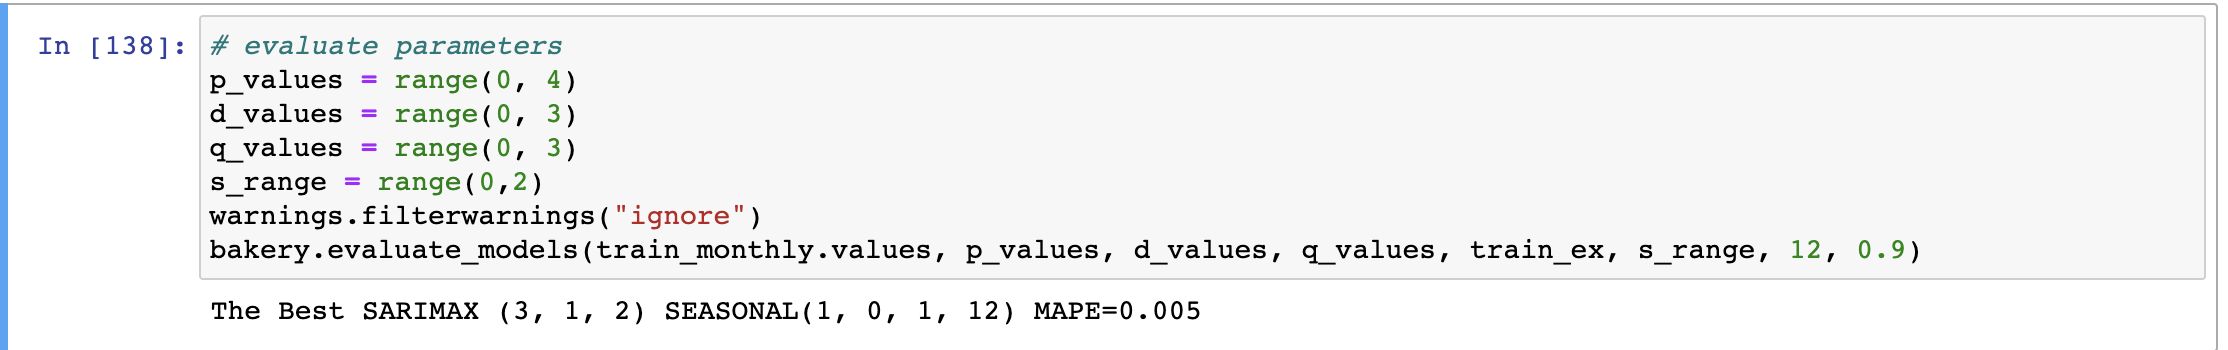

In [206]:
# Run with best hyperparameters
p_param = 3
d_param = 1
q_param = 2

model = SARIMAX(train_monthly, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (1, 0, 1, 12), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        Total_Revenue   No. Observations:                   19
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -202.625
Date:                              Thu, 03 Nov 2022   AIC                            433.249
Time:                                      20:44:30   BIC                            445.714
Sample:                                  09-01-2020   HQIC                           434.968
                                       - 03-01-2022                                         
Covariance Type:                                opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       8918.4489   3.16e+04      0.282      0.778    -5.3e+04    7.08e+04
Bank_Holiday    2.458e+04   9076.292      2.709      0.007    6794.609    4.24e+04
Closed_Xmas     1197.6227   1.55e+04      0.077      0.939   -2.92e+04    3.16e+04
School_Holiday  3.111e+04   9845.378      3.160      0.002    1.18e+04    5.04e+04
Weekday         2.974e+04   8818.769      3.372      0.001    1.25e+04     4.7e+04
Weekend         2.139e+04   1.37e+04      1.561      0.118   -5465.917    4.83e+04
ar.L1              1.6206      0.185      8.747      0.000       1.258       1.984
ar.L2             -0.8997      0.287     -3.139      0.002      -1.462      -0.338
ar.L3              0.0184      0.138      0.134      0.893      -0.251       0.288
ma.L1             -1.5524      0.137    -11.308      0.000      -1.821      -1.283
ma.L2              0.8925      0.151      5.904      0.000       0.596       1.189
ar.S.L12          -0.9537      6.907     -0.138      0.890     -14.490      12.583
ma.S.L12           0.9705      7.450      0.130      0.896     -13.632      15.573
sigma2          3.615e+08      3.873   9.33e+07      0.000    3.61e+08    3.61e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.42   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.12   Prob(JB):                         0.90
Heteroskedasticity (H):               0.78   Skew:                            -0.07
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.42e+23. Standard errors may be unstable.
"""

In [207]:
predictions_5 = model_fit.predict(start=0, end=len(train_monthly)+len(test_monthly)-1, exog=test_ex)

In [208]:
bakery.train_forecast_plot(train_monthly, test_monthly, predictions_5, 
                           'Model 5 - Monthly Forecast with Holiday Dates and Tuned Parameters')

In [209]:
bakery.full_accuracy_report(test_monthly, predictions_5[test_monthly.index], 'monthly forecast with holiday dates')

The R2 for the monthly forecast with holiday dates is: 0.584

The RMSE for the monthly forecast with holiday dates is: 36553.08

The MAE between the actual and monthly forecast with holiday dates revenue is 26064.25

The MAPE between the actual and monthly forecast with holiday dates revenue is 7.1%


## Model 5 Monthly Accuracy Evaluation 
Tihs has dramatically improved the accuracy of the model, achieving a MAPE score of 7.1% and a positive R<sup>2</sup> score. 

From the summary report, `Bank_Holiday` and `Closed_Xmas` both have p-values greater than 0.05, therefore these variables will be removed from the model to try and improve the results.

In [210]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 5, 0.584, 36553.08, 433.249, '7.1%',
                                  'Tuned parameters, p=3, d=1, q=2')

Model     R2       RMSE       AIC MAPE (%)  \
0      1 -4.565  133669.38  1008.592    30.0%   
1      2 -2.904  111963.55   463.250    22.8%   
2      3 -4.565  133669.38   453.287    30.0%   
3      4 -2.719  109276.81   448.180    27.0%   
4      5  0.584   36553.08   433.249     7.1%   

                                Comments  
0                Baseline, p=0, d=1, q=0  
1        Tuned parameters, p=3, d=1, q=1  
2      Reduced parameters, p=0, d=2, q=0  
3  Baseline holiday dates, p=0, d=1, q=0  
4        Tuned parameters, p=3, d=1, q=2

# Model 6 - Removing Variables with P-Values Greater than 0.05
`Bank_Holiday` and `Closed_Xmas` will be removed as they are the two independent variables with the greatest p-values. 

In [211]:
train_ex_red=train_ex.drop(columns=['Closed_Xmas', 'Bank_Holiday'])
test_ex_red = test_ex.drop(columns=['Closed_Xmas', 'Bank_Holiday'])

In [212]:
# Run with reduced hyperparameters
p_param = 3
d_param = 1
q_param = 2

model = SARIMAX(train_monthly, exog=train_ex_red,
                      order=(p_param, d_param, q_param), seasonal_order = (1, 0, 1, 12), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        Total_Revenue   No. Observations:                   19
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -214.455
Date:                              Thu, 03 Nov 2022   AIC                            452.911
Time:                                      20:44:30   BIC                            463.595
Sample:                                  09-01-2020   HQIC                           454.384
                                       - 03-01-2022                                         
Covariance Type:                                opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       9635.4349   4.53e+05      0.021      0.983   -8.79e+05    8.98e+05
School_Holiday  2.436e+04   5364.635      4.540      0.000    1.38e+04    3.49e+04
Weekday         1.764e+04   5084.647      3.470      0.001    7678.105    2.76e+04
Weekend         2.524e+04   7731.402      3.265      0.001    1.01e+04    4.04e+04
ar.L1             -0.0307      8.684     -0.004      0.997     -17.050      16.989
ar.L2              0.3614      1.074      0.337      0.736      -1.744       2.466
ar.L3             -0.0370      2.482     -0.015      0.988      -4.902       4.828
ma.L1              0.2583      8.615      0.030      0.976     -16.627      17.144
ma.L2             -0.1018      2.937     -0.035      0.972      -5.858       5.654
ar.S.L12           0.3090     34.497      0.009      0.993     -67.304      67.922
ma.S.L12          -0.1630     35.261     -0.005      0.996     -69.274      68.948
sigma2          7.436e+08    478.999   1.55e+06      0.000    7.44e+08    7.44e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.37   Prob(JB):                         0.70
Heteroskedasticity (H):               1.09   Skew:                             0.45
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.97e+21. Standard errors may be unstable.
"""

In [213]:
predictions_6 = model_fit.predict(start=0, end=len(train_monthly)+len(test_monthly)-1, exog=test_ex_red)

In [214]:
bakery.train_forecast_plot(train_monthly, test_monthly, predictions_6, 
                           'Model 6 - Monthly Forecast Removing Xmas and Bank Holiday')

In [215]:
bakery.full_accuracy_report(test_monthly, predictions_6[test_monthly.index], 
                            'monthly forecast reducing hyperparameters')

The R2 for the monthly forecast reducing hyperparameters is: 0.443

The RMSE for the monthly forecast reducing hyperparameters is: 42291.41

The MAE between the actual and monthly forecast reducing hyperparameters revenue is 35348.57

The MAPE between the actual and monthly forecast reducing hyperparameters revenue is 9.4%


## Model 6 Monthly Accuracy Evaluation 
This has slightly increased the MAPE score, however is still relatively accurate model, with a positive R<sup>2</sup>. 

Finally the hyperparameters will be reduced that don't appear to be statistically significant from this model. 

In [216]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 6, 0.443, 42291.41, 452.911, '9.4%',
                                  'Removing Xmas, weekday, p=3, d=1, q=2')

Model     R2       RMSE       AIC MAPE (%)  \
0      1 -4.565  133669.38  1008.592    30.0%   
1      2 -2.904  111963.55   463.250    22.8%   
2      3 -4.565  133669.38   453.287    30.0%   
3      4 -2.719  109276.81   448.180    27.0%   
4      5  0.584   36553.08   433.249     7.1%   
5      6  0.443   42291.41   452.911     9.4%   

                                Comments  
0                Baseline, p=0, d=1, q=0  
1        Tuned parameters, p=3, d=1, q=1  
2      Reduced parameters, p=0, d=2, q=0  
3  Baseline holiday dates, p=0, d=1, q=0  
4        Tuned parameters, p=3, d=1, q=2  
5  Removing Xmas, weekday, p=3, d=1, q=2

# Model 7 -  Reducing Hyperparameters with P-Values greater than 0.05
All of the autoregressive and the moving average coefficients have p-values greater than 0.05, therefore will be reduced to 0 for the next iteration of the model.

In [217]:
# Run with best hyperparameters
p_param = 0
d_param = 2
q_param = 0

model = SARIMAX(train_monthly, exog=train_ex_red,
                      order=(p_param, d_param, q_param), seasonal_order = (0, 0, 0, 12), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Total_Revenue   No. Observations:                   19
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -205.267
Date:                Thu, 03 Nov 2022   AIC                            420.533
Time:                        20:44:30   BIC                            424.699
Sample:                    09-01-2020   HQIC                           420.947
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       5111.5752   1.16e+04      0.439      0.661   -1.77e+04    2.79e+04
School_Holiday  2.536e+04   6162.682      4.116      0.000    1.33e+04    3.74e+04
Weekday         1.932e+04   6575.754      2.938      0.003    6428.552    3.22e+04
Weekend         2.448e+04   6918.843      3.538      0.000    1.09e+04     3.8e+04
sigma2            1.8e+09   1.13e+09      1.600      0.110   -4.06e+08    4.01e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.61   Prob(JB):                         0.72
Heteroskedasticity (H):               0.49   Skew:                            -0.44
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [218]:
predictions_7 = model_fit.predict(start=0, end=len(train_monthly)+len(test_monthly)-1, exog=test_ex_red)

In [219]:
bakery.train_forecast_plot(train_monthly, test_monthly, predictions_7, 
                           'Model 7 - Monthly Forecast Reducing Hyperparameters')

In [220]:
bakery.full_accuracy_report(test_monthly, predictions_7[test_monthly.index], 
                            'monthly forecast reducing special dates')

The R2 for the monthly forecast reducing special dates is: -1.149

The RMSE for the monthly forecast reducing special dates is: 83060.87

The MAE between the actual and monthly forecast reducing special dates revenue is 63000.77

The MAPE between the actual and monthly forecast reducing special dates revenue is 16.5%


## Model 7 Monthly Accuracy Evaluation 
This has produced a less accurate model as the MAPE score has increased and the R<sup>2</sup> score is negative. However, all the p-values are less than 0.05, suggesting they are statistically significant. 

In [221]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 7, -1.149, 83060.87, 420.533, '16.5%',
                                  'Reducing hyperparameters, p=0, d=1, q=0')

Model     R2       RMSE       AIC MAPE (%)  \
0      1 -4.565  133669.38  1008.592    30.0%   
1      2 -2.904  111963.55   463.250    22.8%   
2      3 -4.565  133669.38   453.287    30.0%   
3      4 -2.719  109276.81   448.180    27.0%   
4      5  0.584   36553.08   433.249     7.1%   
5      6  0.443   42291.41   452.911     9.4%   
6      7 -1.149   83060.87   420.533    16.5%   

                                  Comments  
0                  Baseline, p=0, d=1, q=0  
1          Tuned parameters, p=3, d=1, q=1  
2        Reduced parameters, p=0, d=2, q=0  
3    Baseline holiday dates, p=0, d=1, q=0  
4          Tuned parameters, p=3, d=1, q=2  
5    Removing Xmas, weekday, p=3, d=1, q=2  
6  Reducing hyperparameters, p=0, d=1, q=0

---

# Monthly Revenue Model Results Discussion 
Of the 7 models that were run, model 5 produced the lowest AIC, RMSE and MAPE scores and a positive R<sup>2</sup> score which only two of the models achieved, therefore is deemed the most accurate model for the monthly forecast. This has also scored the lowest accuracy scores compared to the moving average and linear regression models, making it the most accurate model so far for predicting monthly revenue. 

In addition to this, unlike the weekly model, by looking at the graph of the predicted values versus the true, except for the intial outlier point, the rest of the values fit very well without any sporadic predictions, suggesting it will be a successful model when implemented in real life. 

In [222]:
# Re-running best model 
p_param = 3
d_param = 1
q_param = 2

model = SARIMAX(train_monthly, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (1, 0, 1, 12), trend='c')
monthly_model_fit = model.fit(disp=0)

In [223]:
# To save the monthly model 
joblib.dump(monthly_model_fit, 'sarimax_monthly_model.pkl') 

['sarimax_monthly_model.pkl']

In [224]:
# To validate it saved correctly the same summary as for model 5 should be displayed 
monthly_model_test = joblib.load('sarimax_monthly_model.pkl') 
display(monthly_model_test.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        Total_Revenue   No. Observations:                   19
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -202.625
Date:                              Thu, 03 Nov 2022   AIC                            433.249
Time:                                      20:44:31   BIC                            445.714
Sample:                                  09-01-2020   HQIC                           434.968
                                       - 03-01-2022                                         
Covariance Type:                                opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       8918.4489   3.16e+04      0.282      0.778    -5.3e+04    7.08e+04
Bank_Holiday    2.458e+04   9076.292      2.709      0.007    6794.609    4.24e+04
Closed_Xmas     1197.6227   1.55e+04      0.077      0.939   -2.92e+04    3.16e+04
School_Holiday  3.111e+04   9845.378      3.160      0.002    1.18e+04    5.04e+04
Weekday         2.974e+04   8818.769      3.372      0.001    1.25e+04     4.7e+04
Weekend         2.139e+04   1.37e+04      1.561      0.118   -5465.917    4.83e+04
ar.L1              1.6206      0.185      8.747      0.000       1.258       1.984
ar.L2             -0.8997      0.287     -3.139      0.002      -1.462      -0.338
ar.L3              0.0184      0.138      0.134      0.893      -0.251       0.288
ma.L1             -1.5524      0.137    -11.308      0.000      -1.821      -1.283
ma.L2              0.8925      0.151      5.904      0.000       0.596       1.189
ar.S.L12          -0.9537      6.907     -0.138      0.890     -14.490      12.583
ma.S.L12           0.9705      7.450      0.130      0.896     -13.632      15.573
sigma2          3.615e+08      3.873   9.33e+07      0.000    3.61e+08    3.61e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.42   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.12   Prob(JB):                         0.90
Heteroskedasticity (H):               0.78   Skew:                            -0.07
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.42e+23. Standard errors may be unstable.
"""

#  Exploring Reisudals of Best Monthly Model
To further evaluate the best models performance, the model residuals will be explored. For an accurate linear model, the assumptions are that: 
- Residuals are normally distributed
- Homoscedasticity: Variance of error terms are similar across the values of the independent variables
- The ACF of the residuals should show no significant correlations 

In [225]:
model_resids = monthly_model_fit.resid
model_fitted = monthly_model_fit.fittedvalues

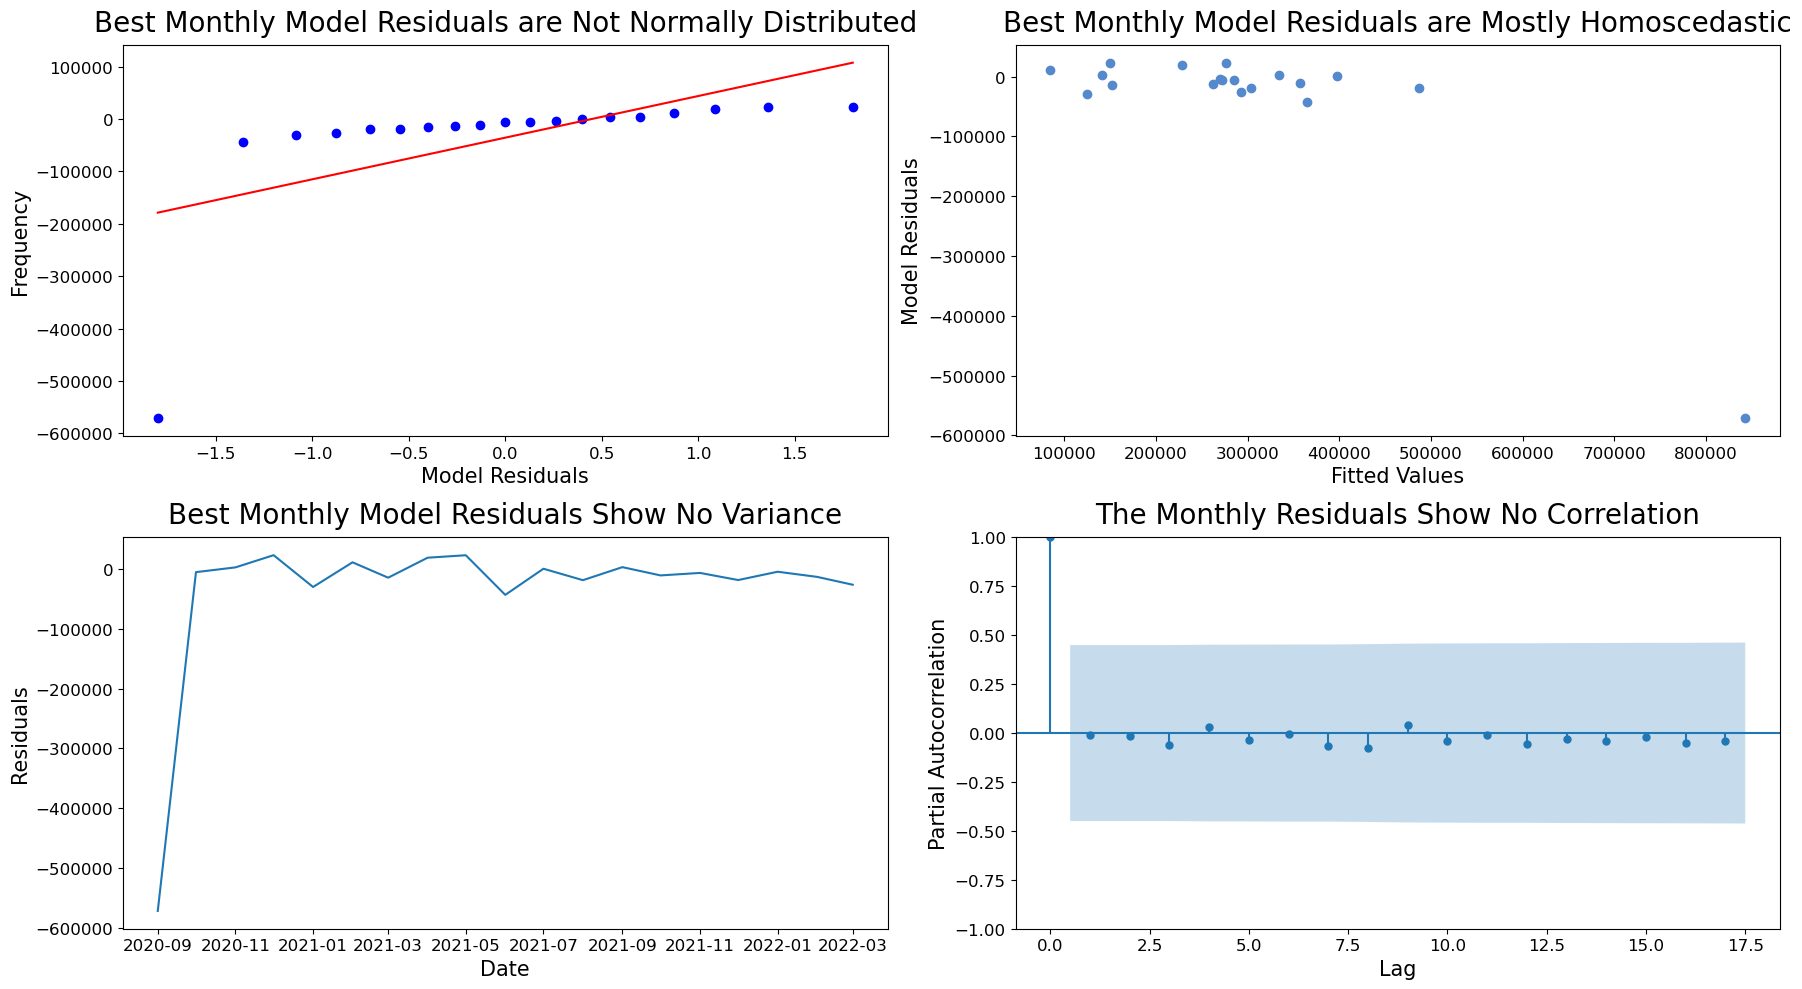

In [226]:
bakery.plot_residuals(model_resids, model_fitted, 'Best Monthly Model Residuals are Not Normally Distributed', 
               'Best Monthly Model Residuals are Mostly Homoscedastic', 
               'Best Monthly Model Residuals Show No Variance', 'The Monthly Residuals Show No Correlation')

## Monthly Model Evaluation 
From the ACF plot and the model residuals vs fitted values it can be seen that there is little variance and no correlation between residuals

However, the residuals are not normally distributed, this is due to the first predicted outlier point, which can be seen in the graph of the predicted vs actual revenue for model 5. Therefore, to re-assess this outlier prediction will be removed and the residuals re-plotted. 

In [227]:
model_resids_red = model_resids[1:]
model_fitted_red = model_fitted[1:]
# To validate it worked 
model_resids_red.tail()

2021-11-01    -6496.472657
2021-12-01   -18400.078818
2022-01-01    -4507.925171
2022-02-01   -13110.212386
2022-03-01   -26253.139569
Freq: MS, dtype: float64

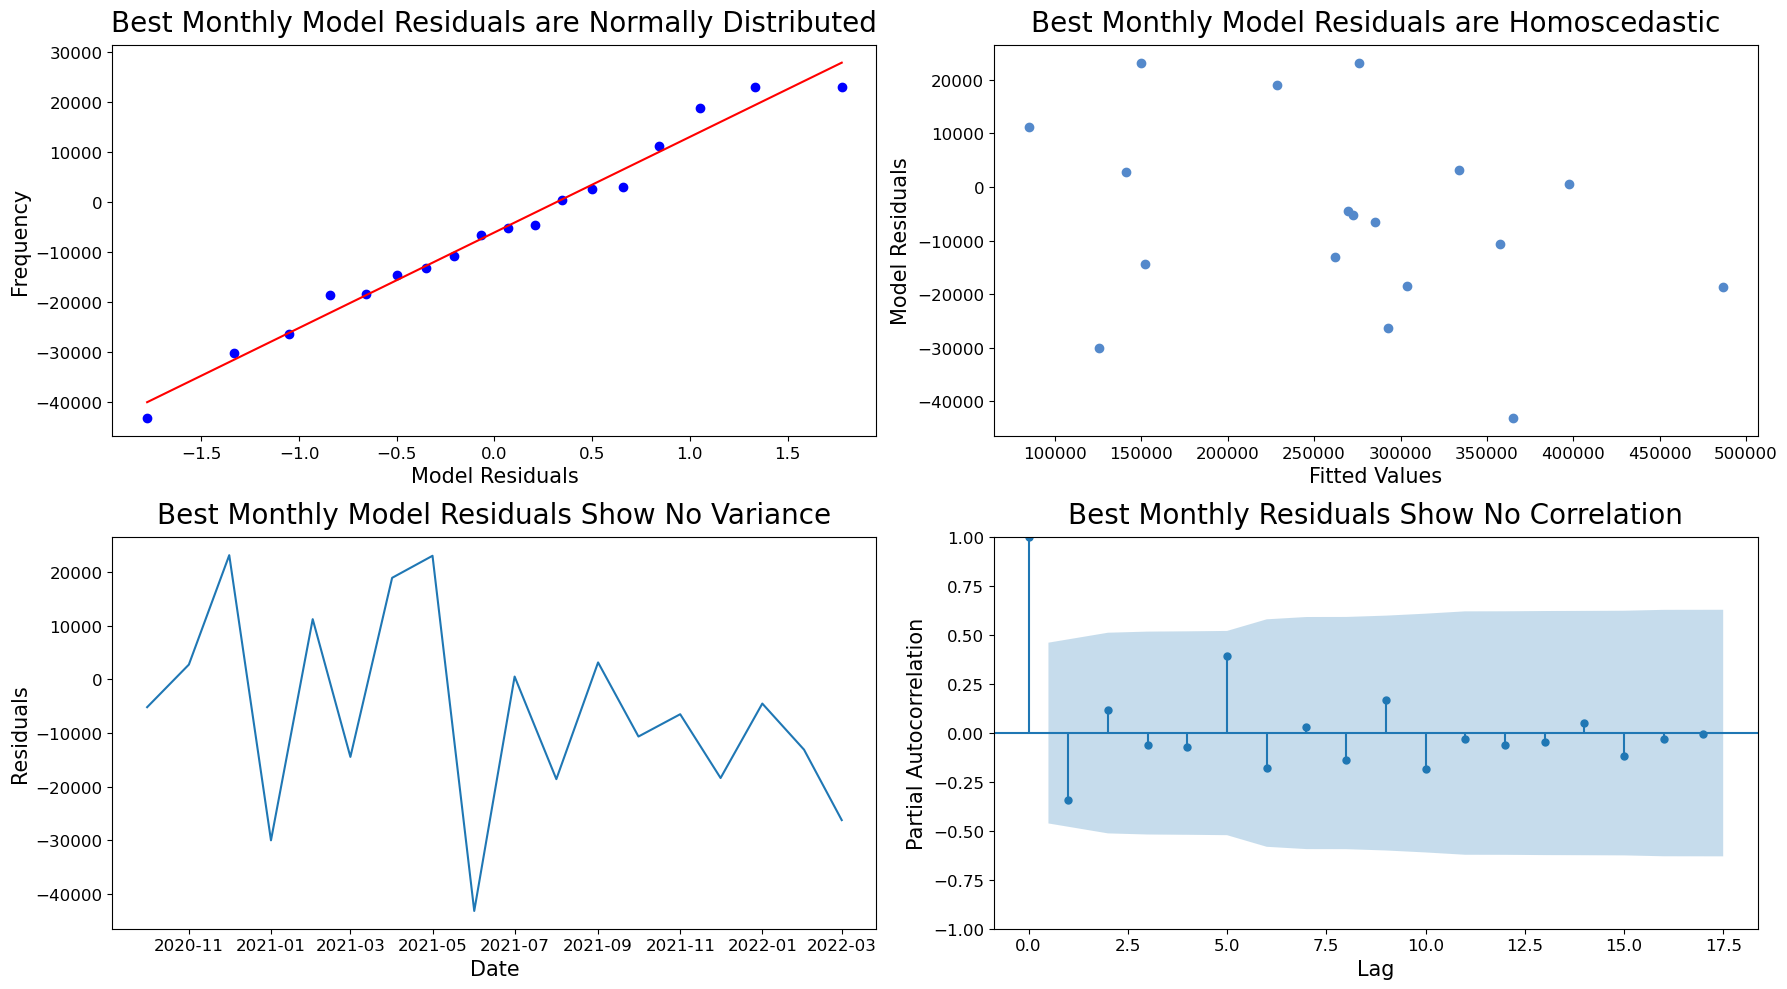

In [228]:
# To plot the residual plots
bakery.plot_residuals(model_resids_red, model_fitted_red,
                      'Best Monthly Model Residuals are Normally Distributed', 
               'Best Monthly Model Residuals are Homoscedastic', 
               'Best Monthly Model Residuals Show No Variance', 'Best Monthly Residuals Show No Correlation')

# Summary 
The best models for each forecast are summarised in the table below, along with their MAPE scores and model number.

|Forecast| Model | MAPE |
|:--| :- | :- | 
|Daily|7| 5.9 %|
|Weekly|7| 8.2 %|
|Monthly|5| 7.1 %|

The [Daily](#Model-7---Reducing-p_param-and-q_param) and [Monthly](#Model-7---Reducing-Hyperparameters-with-P-Values-greater-than-0.05) models appear to fit true values very well, following the fluctuations in the actual dataset well. Whereas, the [Weekly](#Model-5---Removing-Variables-with-P-Values-Greater-than-0.05) forecast appears to fluctuate a low and appear to be sporadic in the predictions. It has achieved a relatively low MAPE score, which indicates it could be good at predicting future revenue, however should be tested that that remains the case for future unknown data points. 

All of these models are now the leading and best models compared to the moving average and linear regression models, which have their MAPE scores summarised below. 

|MAPE Score| Moving Average | Linear Regression | SARIMAX|
|:--| :- | :- | :--|
|Daily|20.7 %| 7.7 %|  5.9 % |
|Weekly |24.8 %| 9.9 %| 8.2 %|
|Monthly|17.0 %|13.3 %| 7.1 %|



---

# Further Improvements
Further improvements that could be made to the models are: 
- Re-run the analysis with more historic revenue data, inparticular for the weekly and monthly forecasts which have fewer data points 
- Include statistical features from the historic data in the exogenous data, such as a lagged moving average (as in the linear regression model) 
- Run in depth cross-validation on the data to improve results. This was not carried out as it was deemed that there were too few data points for it to run successfully for the weekly and monthly forecasts 

# Next Steps
- Facebook Prophet models will be developed for the daily, weekly or monthly forecast to see if this improves the accuracy from the SARIMAX models, found here [Facebook Prophet Modelling Notebook](./9_Model_4_Faceboook_Prophet.ipynb)

>[Return to Contents](#Contents)